In [5]:
# creating a reuseable function that will help us in ploting our barplots for analysis

def BarPlot(df, Variable, plotSize):
    fig, axs = plt.subplots(figsize = plotSize)
    plt.xticks(rotation = 45)
    ax = sns.countplot(x=Variable, data=df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/len(df) * 100),
                ha="center")

In [6]:
# creating a reuseable function that will help us in Bivariate for analysis
def CountPlot(df,Variable,title,plotsize,hue=None):
    plt.figure(figsize=plotsize)
    plt.xticks(rotation=90)
    plt.title(title)
    sns.countplot(data = df, x=Variable, order=df[Variable].value_counts().index,hue = hue)
    plt.show()
    
    convertcount=df.pivot_table(values='Lead Number',index=Variable,columns='Converted', aggfunc='count').fillna(0)
    convertcount["Conversion(%)"] =round(convertcount[1]/(convertcount[0]+convertcount[1]),2)*100
    return print(convertcount.sort_values(ascending=False,by="Conversion(%)"))


## Step 1: Reading and Understanding the Data

In [7]:
#Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importing RFE and LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [8]:
# Reading File
df= pd.read_csv("Leads.csv")

In [9]:
df.head(20)

Prospect ID  Lead Number  \
0   7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737   
1   2a272436-5132-4136-86fa-dcc88c88f482       660728   
2   8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727   
3   0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719   
4   3256f628-e534-4826-9d63-4a8b88782852       660681   
5   2058ef08-2858-443e-a01f-a9237db2f5ce       660680   
6   9fae7df4-169d-489b-afe4-0f3d752542ed       660673   
7   20ef72a2-fb3b-45e0-924e-551c5fa59095       660664   
8   cfa0128c-a0da-4656-9d47-0aa4e67bf690       660624   
9   af465dfc-7204-4130-9e05-33231863c4b5       660616   
10  2a369e35-ca95-4ca9-9e4f-9d27175aa320       660608   
11  9bc8ce93-6144-49e0-9f9d-080fc980f83c       660570   
12  8bf76a52-2478-476b-8618-1688e07874ad       660562   
13  88867067-3750-4753-8d33-1c7d1db53b5e       660558   
14  a8531c22-fcf1-48f8-a711-fb5abf98ad87       660553   
15  25f4ac14-ff4b-4cd2-9c61-b44c85e19c8f       660547   
16  3abb7c77-1634-4083-9a9f-861068220611       660540   
17  e5c3beca-a0b6-4b3f-8c01-0919fb9ca3f2       660534   
18  82cb5fb0-2d97-4a39-a630-ab5fe2e7f18c       660522   
19  4512c16a-e96a-4459-b9ec-c7d8fe8c4880       660509   

                Lead Origin     Lead Source Do Not Email Do Not Call  \
0                       API      Olark Chat           No          No   
1                       API  Organic Search           No          No   
2   Landing Page Submission  Direct Traffic           No          No   
3   Landing Page Submission  Direct Traffic           No          No   
4   Landing Page Submission          Google           No          No   
5                       API      Olark Chat           No          No   
6   Landing Page Submission          Google           No          No   
7                       API      Olark Chat           No          No   
8   Landing Page Submission  Direct Traffic           No          No   
9                       API          Google           No          No   
10  Landing Page Submission  Organic Search           No          No   
11  Landing Page Submission  Direct Traffic           No          No   
12                      API  Organic Search           No          No   
13  Landing Page Submission  Organic Search           No          No   
14  Landing Page Submission  Direct Traffic          Yes          No   
15                      API  Organic Search           No          No   
16                      API      Olark Chat           No          No   
17                      API  Referral Sites           No          No   
18  Landing Page Submission          Google           No          No   
19                      API  Organic Search           No          No   

    Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0           0          0.0                            0                  0.00   
1           0          5.0                          674                  2.50   
2           1          2.0                         1532                  2.00   
3           0          1.0                          305                  1.00   
4           1          2.0                         1428                  1.00   
5           0          0.0                            0                  0.00   
6           1          2.0                         1640                  2.00   
7           0          0.0                            0                  0.00   
8           0          2.0                           71                  2.00   
9           0          4.0                           58                  4.00   
10          1          8.0                         1351                  8.00   
11          1          8.0                         1343                  2.67   
12          1         11.0                         1538                 11.00   
13          0          5.0                          170                  5.00   
14          0          1.0                          481                  1.00   
15          1         

In [10]:
# Getting Original onversion rate for the data set
orgConversionRate = round(100*(sum(df['Converted'])/len(df['Converted'].index)), 2)
print("The conversion rate of leads is: ",orgConversionRate)

The conversion rate of leads is:  38.54


In [11]:
# Checking shape of dataframe
df.shape

(9240, 37)

In [12]:
# Checking columns name
df.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [13]:
# Checking columns type in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [14]:
# checking attributes for continuous variables
df.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     7.000000   
25%                1.000000                    14.000000   
50%                2.000000                    14.000000   
75%                3.000000                    15.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 5022.000000  
mean                    16.344883  
std                      1.811395  
min                     11.000000  
25%                     15.000000  
50%                     16.000000  
75%                     18.000000  
max                     20.000000

#### Observation
The shape of the dataset is 9240x37

Original conversion rate of company X is 38.54%.

Large number of 'Select' values present for Lead Profile and City in the dataset. These values correspond to the user having   not made any selection.

There are 7 numerical columns and 30 categorical columns

In [15]:
# AS Value  select represent that User has not selecte any values for that, Hence it can be converted to Null
# so that it can be treated as Null
df = df.replace('Select', np.nan)
df.head(20)

Prospect ID  Lead Number  \
0   7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737   
1   2a272436-5132-4136-86fa-dcc88c88f482       660728   
2   8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727   
3   0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719   
4   3256f628-e534-4826-9d63-4a8b88782852       660681   
5   2058ef08-2858-443e-a01f-a9237db2f5ce       660680   
6   9fae7df4-169d-489b-afe4-0f3d752542ed       660673   
7   20ef72a2-fb3b-45e0-924e-551c5fa59095       660664   
8   cfa0128c-a0da-4656-9d47-0aa4e67bf690       660624   
9   af465dfc-7204-4130-9e05-33231863c4b5       660616   
10  2a369e35-ca95-4ca9-9e4f-9d27175aa320       660608   
11  9bc8ce93-6144-49e0-9f9d-080fc980f83c       660570   
12  8bf76a52-2478-476b-8618-1688e07874ad       660562   
13  88867067-3750-4753-8d33-1c7d1db53b5e       660558   
14  a8531c22-fcf1-48f8-a711-fb5abf98ad87       660553   
15  25f4ac14-ff4b-4cd2-9c61-b44c85e19c8f       660547   
16  3abb7c77-1634-4083-9a9f-861068220611       660540   
17  e5c3beca-a0b6-4b3f-8c01-0919fb9ca3f2       660534   
18  82cb5fb0-2d97-4a39-a630-ab5fe2e7f18c       660522   
19  4512c16a-e96a-4459-b9ec-c7d8fe8c4880       660509   

                Lead Origin     Lead Source Do Not Email Do Not Call  \
0                       API      Olark Chat           No          No   
1                       API  Organic Search           No          No   
2   Landing Page Submission  Direct Traffic           No          No   
3   Landing Page Submission  Direct Traffic           No          No   
4   Landing Page Submission          Google           No          No   
5                       API      Olark Chat           No          No   
6   Landing Page Submission          Google           No          No   
7                       API      Olark Chat           No          No   
8   Landing Page Submission  Direct Traffic           No          No   
9                       API          Google           No          No   
10  Landing Page Submission  Organic Search           No          No   
11  Landing Page Submission  Direct Traffic           No          No   
12                      API  Organic Search           No          No   
13  Landing Page Submission  Organic Search           No          No   
14  Landing Page Submission  Direct Traffic          Yes          No   
15                      API  Organic Search           No          No   
16                      API      Olark Chat           No          No   
17                      API  Referral Sites           No          No   
18  Landing Page Submission          Google           No          No   
19                      API  Organic Search           No          No   

    Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0           0          0.0                            0                  0.00   
1           0          5.0                          674                  2.50   
2           1          2.0                         1532                  2.00   
3           0          1.0                          305                  1.00   
4           1          2.0                         1428                  1.00   
5           0          0.0                            0                  0.00   
6           1          2.0                         1640                  2.00   
7           0          0.0                            0                  0.00   
8           0          2.0                           71                  2.00   
9           0          4.0                           58                  4.00   
10          1          8.0                         1351                  8.00   
11          1          8.0                         1343                  2.67   
12          1         11.0                         1538                 11.00   
13          0          5.0                          170                  5.00   
14          0          1.0                          481                  1.00   
15          1         

In [16]:
# Checking if any duplicate value in Lead Number and Prospect ID
print(sum(df.duplicated(subset= 'Lead Number'))!=0)
print(sum(df.duplicated(subset= 'Prospect ID'))!=0)

False
False


#### Observation
No Duplicates value for Prospect ID and Lead Number

In [17]:
# Checking Null Values
print(df.isnull().sum(axis=0))

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [18]:
# Checking column-wise null percentages here
print(round(100*(df.isnull().sum()/len(df)).sort_values(ascending= False), 2))

How did you hear about X Education               78.46
Lead Profile                                     74.19
Lead Quality                                     51.59
Asymmetrique Profile Score                       45.65
Asymmetrique Activity Score                      45.65
Asymmetrique Profile Index                       45.65
Asymmetrique Activity Index                      45.65
City                                             39.71
Specialization                                   36.58
Tags                                             36.29
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Last Activity                                     1.11
Lead Source                                       0.39
Lead Origin                                       0.00
Lead Numbe

#### Observation:
There are some columns with over 50% of null values.


## Step 2: Data Cleaning

In [19]:
# Droping columns having null percentage >50%
df = df.drop(df.columns[df.apply(lambda col: col.isnull().sum()/len(df) > 0.70)], axis=1)
df

Prospect ID  Lead Number  \
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737   
1     2a272436-5132-4136-86fa-dcc88c88f482       660728   
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727   
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719   
4     3256f628-e534-4826-9d63-4a8b88782852       660681   
...                                    ...          ...   
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9       579564   
9236  82a7005b-7196-4d56-95ce-a79f937a158d       579546   
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c       579545   
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9       579538   
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff       579533   

                  Lead Origin     Lead Source Do Not Email Do Not Call  \
0                         API      Olark Chat           No          No   
1                         API  Organic Search           No          No   
2     Landing Page Submission  Direct Traffic           No          No   
3     Landing Page Submission  Direct Traffic           No          No   
4     Landing Page Submission          Google           No          No   
...                       ...             ...          ...         ...   
9235  Landing Page Submission  Direct Traffic          Yes          No   
9236  Landing Page Submission  Direct Traffic           No          No   
9237  Landing Page Submission  Direct Traffic          Yes          No   
9238  Landing Page Submission          Google           No          No   
9239  Landing Page Submission  Direct Traffic           No          No   

      Converted  TotalVisits  Total Time Spent on Website  \
0             0          0.0                            0   
1             0          5.0                          674   
2             1          2.0                         1532   
3             0          1.0                          305   
4             1          2.0                         1428   
...         ...          ...                          ...   
9235          1          8.0                         1845   
9236          0          2.0                          238   
9237          0          2.0                          199   
9238          1          3.0                          499   
9239          1          6.0                         1279   

      Page Views Per Visit  ... Update me on Supply Chain Content  \
0                     0.00  ...                                No   
1                     2.50  ...                                No   
2                     2.00  ...                                No   
3                     1.00  ...                                No   
4                     1.00  ...                                No   
...                    ...  ...                               ...   
9235                  2.67  ...                                No   
9236                  2.00  ...                                No   
9237                  2.00  ...                                No   
9238                  3.00  ...                                No   
9239                  3.00  ...                                No   

     Get updates on DM Content                City  \
0                           No                 NaN   
1                           No                 NaN   
2                           No              Mumbai   
3                           No              Mumbai   
4                           No              Mumbai   
...                        ...                 ...   
9235                        No              Mumbai   
9236                        No              Mumbai   
9237                        No              Mumbai   
9238                        No  Other Metro Cities   
9239                        No        Other Cities   

     Asymmetrique Activity Index Asymmetrique Profile Index  \
0                      02.Medium                  02.Medium   
1                      02.Medium                  02.Medium   
2                      02.Medium 

In [20]:
## Checking number of unique values per column 
df.nunique()

Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                         5
Lead Source                                        21
Do Not Email                                        2
Do Not Call                                         2
Converted                                           2
TotalVisits                                        41
Total Time Spent on Website                      1731
Page Views Per Visit                              114
Last Activity                                      17
Country                                            38
Specialization                                     18
What is your current occupation                     6
What matters most to you in choosing a course       3
Search                                              2
Magazine                                            1
Newspaper Article                                   2
X Education Forums          

#### Observation
There are a lot of columns with 1 or two unique values.

Below are the columns that have only one unique value, since they won't have anything to contribute to the model significantly,  we will remove these columns.

- Get updates on DM Content
-  Update me on Supply Chain Content
- I agree to pay the amount through cheque
- Receive More Updates About Our Courses
- Magazine

Note: There are no null values in these columns as seen from the null values table above.

In [21]:
df = df.drop(df.columns [df.apply(lambda col: col.nunique()==1)], axis=1)
df

Prospect ID  Lead Number  \
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737   
1     2a272436-5132-4136-86fa-dcc88c88f482       660728   
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727   
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719   
4     3256f628-e534-4826-9d63-4a8b88782852       660681   
...                                    ...          ...   
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9       579564   
9236  82a7005b-7196-4d56-95ce-a79f937a158d       579546   
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c       579545   
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9       579538   
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff       579533   

                  Lead Origin     Lead Source Do Not Email Do Not Call  \
0                         API      Olark Chat           No          No   
1                         API  Organic Search           No          No   
2     Landing Page Submission  Direct Traffic           No          No   
3     Landing Page Submission  Direct Traffic           No          No   
4     Landing Page Submission          Google           No          No   
...                       ...             ...          ...         ...   
9235  Landing Page Submission  Direct Traffic          Yes          No   
9236  Landing Page Submission  Direct Traffic           No          No   
9237  Landing Page Submission  Direct Traffic          Yes          No   
9238  Landing Page Submission          Google           No          No   
9239  Landing Page Submission  Direct Traffic           No          No   

      Converted  TotalVisits  Total Time Spent on Website  \
0             0          0.0                            0   
1             0          5.0                          674   
2             1          2.0                         1532   
3             0          1.0                          305   
4             1          2.0                         1428   
...         ...          ...                          ...   
9235          1          8.0                         1845   
9236          0          2.0                          238   
9237          0          2.0                          199   
9238          1          3.0                          499   
9239          1          6.0                         1279   

      Page Views Per Visit  ... Through Recommendations  \
0                     0.00  ...                      No   
1                     2.50  ...                      No   
2                     2.00  ...                      No   
3                     1.00  ...                      No   
4                     1.00  ...                      No   
...                    ...  ...                     ...   
9235                  2.67  ...                      No   
9236                  2.00  ...                      No   
9237                  2.00  ...                      No   
9238                  3.00  ...                      No   
9239                  3.00  ...                      No   

                                     Tags       Lead Quality  \
0             Interested in other courses   Low in Relevance   
1                                 Ringing                NaN   
2     Will revert after reading the email           Might be   
3                                 Ringing           Not Sure   
4     Will revert after reading the email           Might be   
...                                   ...                ...   
9235  Will revert after reading the email  High in Relevance   
9236                   wrong number given           Might be   
9237                       invalid number           Not Sure   
9238                                  NaN                NaN   
9239  Will revert after reading the email           Might be   

                    City Asymmetrique Activity Index  \
0                    NaN                   02.Medium   
1                    NaN                   02.Medium   
2                 Mumbai                   02.Medium  

In [22]:
### We can also drop the column 'Prospect ID' as we already have an identifying column with unique values: 'Lead Number'
df = df.drop('Prospect ID', axis=1)
df.head()

Lead Number              Lead Origin     Lead Source Do Not Email  \
0       660737                      API      Olark Chat           No   
1       660728                      API  Organic Search           No   
2       660727  Landing Page Submission  Direct Traffic           No   
3       660719  Landing Page Submission  Direct Traffic           No   
4       660681  Landing Page Submission          Google           No   

  Do Not Call  Converted  TotalVisits  Total Time Spent on Website  \
0          No          0          0.0                            0   
1          No          0          5.0                          674   
2          No          1          2.0                         1532   
3          No          0          1.0                          305   
4          No          1          2.0                         1428   

   Page Views Per Visit            Last Activity  ... Through Recommendations  \
0                   0.0  Page Visited on Website  ...                      No   
1                   2.5             Email Opened  ...                      No   
2                   2.0             Email Opened  ...                      No   
3                   1.0              Unreachable  ...                      No   
4                   1.0        Converted to Lead  ...                      No   

                                  Tags      Lead Quality    City  \
0          Interested in other courses  Low in Relevance     NaN   
1                              Ringing               NaN     NaN   
2  Will revert after reading the email          Might be  Mumbai   
3                              Ringing          Not Sure  Mumbai   
4  Will revert after reading the email          Might be  Mumbai   

  Asymmetrique Activity Index Asymmetrique Profile Index  \
0                   02.Medium                  02.Medium   
1                   02.Medium                  02.Medium   
2                   02.Medium                    01.High   
3                   02.Medium                    01.High   
4                   02.Medium                    01.High   

  Asymmetrique Activity Score Asymmetrique Profile Score  \
0                        15.0                       15.0   
1                        15.0                       15.0   
2                        14.0                       20.0   
3                        13.0                       17.0   
4                        15.0                       18.0   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified  

[5 rows x 29 columns]

#### Checking all columns individually having null values in order to decide to impute/drop the column
As we can see some of the columns have substantial number of null or missing values. If we drop all these columns we will lose a lot of information so instead of dropping them, for some of the feature variables we will create a new value as 'Unknown' 

#### Asymmetrique Activity/Profile Index Activity and Score



Let us now look at the following columns: Asymmetrique Activity Index, Asymmetrique Profile Index,Asymmetrique Profile Score and Asymmetrique Activity Score.

We know from the data dictionary that these are scores assigned to a customer based on their activity and profile Via X- Education employee after calling to Lead.

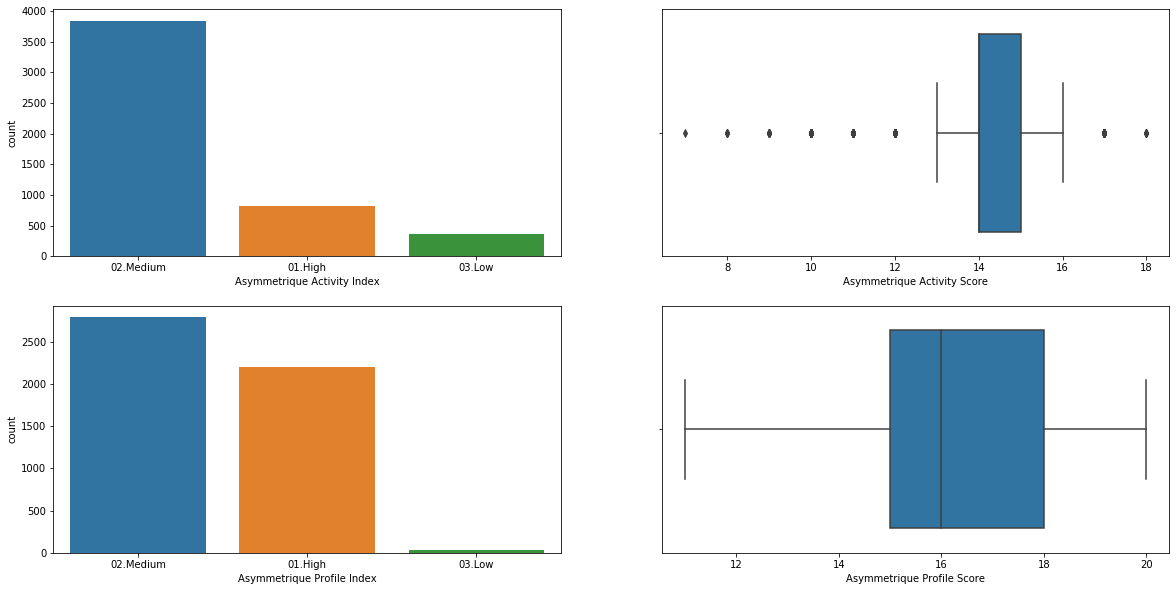

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.countplot(df['Asymmetrique Activity Index'])

plt.subplot(2,2,2)
sns.boxplot(df['Asymmetrique Activity Score'])

plt.subplot(2,2,3)
sns.countplot(df['Asymmetrique Profile Index'])

plt.subplot(2,2,4)
sns.boxplot(df['Asymmetrique Profile Score'])

Observation
There is a lot of variation in the data and the number of null values is also very high at 45.65% and its assigned to leas aster calling them via Employee of X-education. Therefore we will drop these columns.

Let us now drop all the 4 columns: **Asymmetrique Activity Index, Asymmetrique Activity Score, Asymmetrique Profile Index and Asymmetrique Profile Score**.

In [24]:
colsToDrop = ['Asymmetrique Activity Index','Asymmetrique Activity Score','Asymmetrique Profile Index','Asymmetrique Profile Score']
df =df.drop(colsToDrop, axis=1)

#### Lead Quality

In [25]:
# Checking Lead Quality
df['Lead Quality'].value_counts()

Might be             1560
Not Sure             1092
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

In [26]:
# Since 'Lead Quality' is based on an employees intuition, let us inpute any NAN values with 'Not Sure'
df['Lead Quality'] = df['Lead Quality'].fillna('Not Sure')
df['Lead Quality'].value_counts()

Not Sure             5859
Might be             1560
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

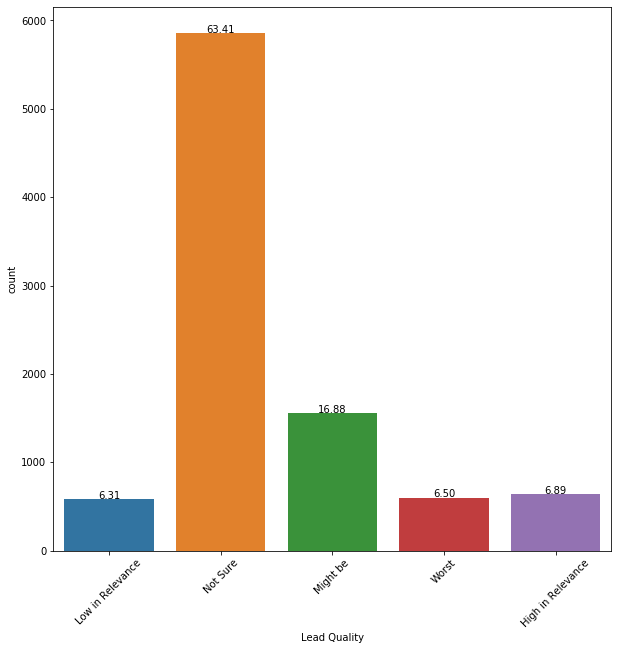

In [27]:
BarPlot(df, 'Lead Quality', (10,10))

##### Observation
From the abover barplot we see that the number of values for 'Not Sure' are considerable high at 63.14%. We will drop this column

In [28]:
df =df.drop('Lead Quality', axis=1)
df

Lead Number              Lead Origin     Lead Source Do Not Email  \
0          660737                      API      Olark Chat           No   
1          660728                      API  Organic Search           No   
2          660727  Landing Page Submission  Direct Traffic           No   
3          660719  Landing Page Submission  Direct Traffic           No   
4          660681  Landing Page Submission          Google           No   
...           ...                      ...             ...          ...   
9235       579564  Landing Page Submission  Direct Traffic          Yes   
9236       579546  Landing Page Submission  Direct Traffic           No   
9237       579545  Landing Page Submission  Direct Traffic          Yes   
9238       579538  Landing Page Submission          Google           No   
9239       579533  Landing Page Submission  Direct Traffic           No   

     Do Not Call  Converted  TotalVisits  Total Time Spent on Website  \
0             No          0          0.0                            0   
1             No          0          5.0                          674   
2             No          1          2.0                         1532   
3             No          0          1.0                          305   
4             No          1          2.0                         1428   
...          ...        ...          ...                          ...   
9235          No          1          8.0                         1845   
9236          No          0          2.0                          238   
9237          No          0          2.0                          199   
9238          No          1          3.0                          499   
9239          No          1          6.0                         1279   

      Page Views Per Visit            Last Activity  ... Search  \
0                     0.00  Page Visited on Website  ...     No   
1                     2.50             Email Opened  ...     No   
2                     2.00             Email Opened  ...     No   
3                     1.00              Unreachable  ...     No   
4                     1.00        Converted to Lead  ...     No   
...                    ...                      ...  ...    ...   
9235                  2.67        Email Marked Spam  ...     No   
9236                  2.00                 SMS Sent  ...     No   
9237                  2.00                 SMS Sent  ...     No   
9238                  3.00                 SMS Sent  ...     No   
9239                  3.00                 SMS Sent  ...     No   

     Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                   No                 No        No                    No   
1                   No                 No        No                    No   
2                   No                 No        No                    No   
3                   No                 No        No                    No   
4                   No                 No        No                    No   
...                ...                ...       ...                   ...   
9235                No                 No        No                    No   
9236                No                 No        No                    No   
9237                No                 No        No                    No   
9238                No                 No        No                    No   
9239                No                 No        No                    No   

     Through Recommendations                                 Tags  \
0                         No          Interested in other courses   
1                         No                              Ringing   
2                         No  Will revert after reading the email   
3                         No                              Ringing   
4                         No  Will revert after reading the email   
...                      ...                                  ...   
9235           

### City

In [29]:
df['City'].value_counts()

Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [30]:
df.City.describe()

count       5571
unique         6
top       Mumbai
freq        3222
Name: City, dtype: object

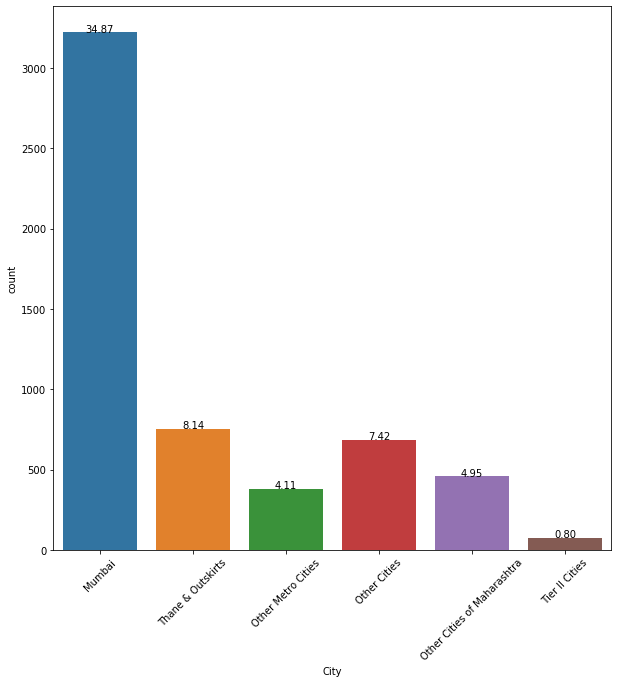

In [31]:
BarPlot(df, 'City', (10,10))

##### Observation
We will impute the missing values with 'Mumbai' since it has the highest count.

In [32]:
df.City= df.City.fillna('Mumbai')

In [33]:
df['City'].value_counts(normalize= True)

Mumbai                         0.745779
Thane & Outskirts              0.081385
Other Cities                   0.074242
Other Cities of Maharashtra    0.049459
Other Metro Cities             0.041126
Tier II Cities                 0.008009
Name: City, dtype: float64

### Specialization

In [34]:
### Exploring 'Specialization' column which hs 36.58% null values
df.Specialization.describe()

count                   5860
unique                    18
top       Finance Management
freq                     976
Name: Specialization, dtype: object

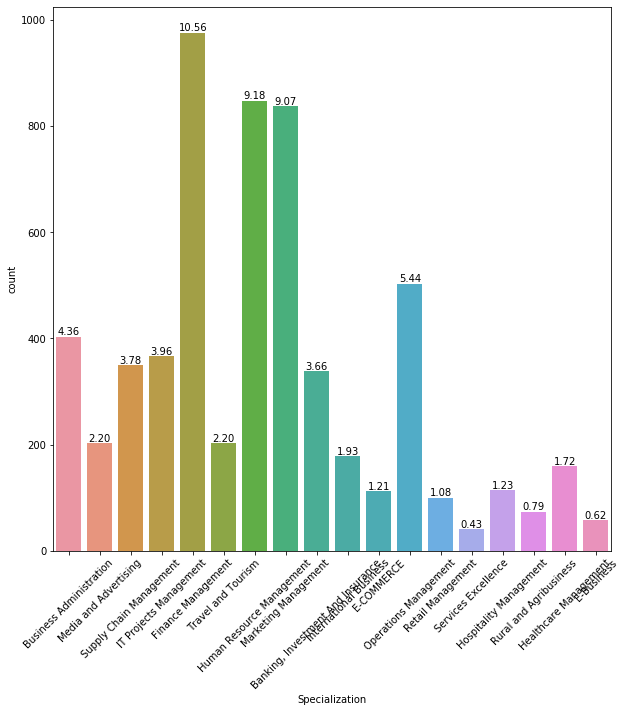

In [35]:
BarPlot(df, 'Specialization', (10,10))

##### Note:
Since there are 36% null values that haven't yet been accounted for, we will replace those with 'Others'. This is being done because the NaN values have the highest percentage of values that haven't been shown above. It simply means that the user did not have any option relevant to them in this field.

In [36]:
df.Specialization= df['Specialization'].fillna('Others')
df.Specialization.value_counts(normalize=True)

Others                               0.365801
Finance Management                   0.105628
Human Resource Management            0.091775
Marketing Management                 0.090693
Operations Management                0.054437
Business Administration              0.043615
IT Projects Management               0.039610
Supply Chain Management              0.037771
Banking, Investment And Insurance    0.036580
Media and Advertising                0.021970
Travel and Tourism                   0.021970
International Business               0.019264
Healthcare Management                0.017208
Hospitality Management               0.012338
E-COMMERCE                           0.012121
Retail Management                    0.010823
Rural and Agribusiness               0.007900
E-Business                           0.006169
Services Excellence                  0.004329
Name: Specialization, dtype: float64

### Tags

In [37]:
df.Tags.describe()

count                                    5887
unique                                     26
top       Will revert after reading the email
freq                                     2072
Name: Tags, dtype: object

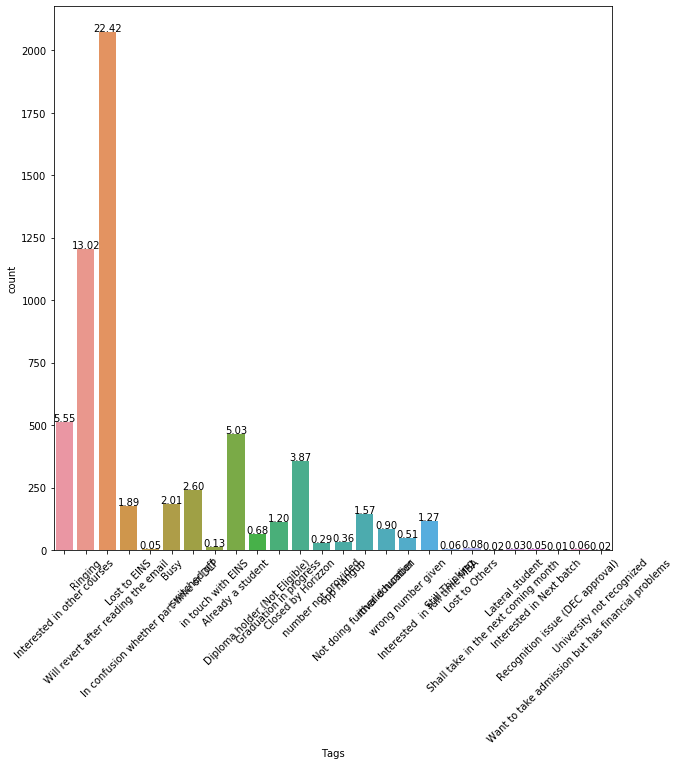

In [38]:
BarPlot(df,'Tags', (10,10))

##### Observation
From the above bar plot it looks like we have a lot of small categories within the tags section. Moreover these tags are added by the sales team. We can safely drop this column as this doesn't provide a lot of insight.

In [39]:
df = df.drop(['Tags'], axis = 1)

In [40]:
# Checking again the Null values
print(round(100*(df.isnull().sum(axis=0)/len(df.index)).sort_values(ascending=False),2))

What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Last Activity                                     1.11
Lead Source                                       0.39
Last Notable Activity                             0.00
Lead Origin                                       0.00
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
Total Time Spent on Website                       0.00
Specialization                                    0.00
A free copy of Mastering The Interview            0.00
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

##### Observation
We still have a few columns that have a high number of null values.

### What matters most to you in choosing a course

In [41]:
df['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

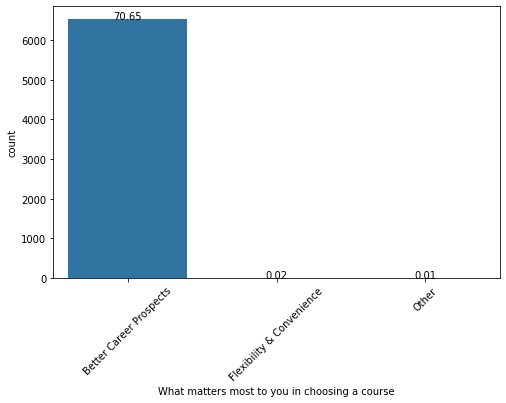

In [42]:
BarPlot(df, 'What matters most to you in choosing a course',(8,5))

##### Observation
We can clearly see that this column is heavily skewed towards better career prospects. Since it doesn't really provide any more information, we can drop this column and keep note that all candidates that take this course are looking to have a better career.

In [43]:
# Dropping 'What matters most to you in choosing a course'
df= df.drop(['What matters most to you in choosing a course'], axis =1)

### What is your current occupation

In [44]:
df['What is your current occupation'].value_counts(normalize= True)

Unemployed              0.854962
Working Professional    0.107786
Student                 0.032061
Other                   0.002443
Housewife               0.001527
Businessman             0.001221
Name: What is your current occupation, dtype: float64

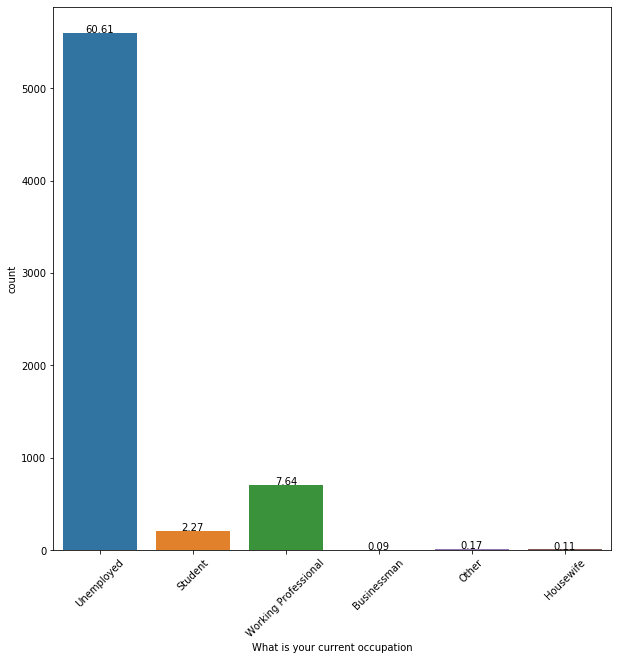

In [45]:
BarPlot(df, 'What is your current occupation',(10,10))

##### Observation
The data in this column looks skewed, however, it also defines potential target market for company X. We will impute the missing values with 'Unemployed' and drop the column if analysis further down seems it necessary

In [46]:
df['What is your current occupation']=df['What is your current occupation'].fillna('Unemployed')

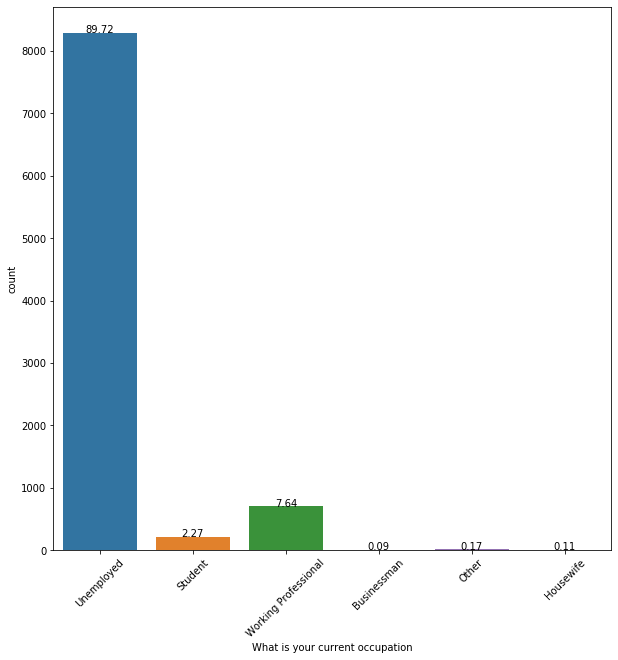

In [47]:
BarPlot(df, 'What is your current occupation',(10,10))

### Country

In [48]:
df['Country'].value_counts()

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Nigeria                    4
Kuwait                     4
Canada                     4
Germany                    4
South Africa               4
Sweden                     3
Bangladesh                 2
Philippines                2
Asia/Pacific Region        2
Belgium                    2
Netherlands                2
Italy                      2
China                      2
Ghana                      2
Uganda                     2
Sri Lanka                  1
Indonesia                  1
Russia                     1
Switzerland                1
Malaysia                   1
Vietnam                    1
Tanzania      

In [49]:
df['Country'].describe()

count      6779
unique       38
top       India
freq       6492
Name: Country, dtype: object

##### Note
Since a mode value for this column is India, we can replace the missing values with India. Since this will potentially skew the data heavily in the model we will drop this column.

In [50]:
df['Country']= df['Country'].fillna('India')
df['Country'].value_counts()

India                   8953
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Nigeria                    4
Kuwait                     4
Canada                     4
Germany                    4
South Africa               4
Sweden                     3
Bangladesh                 2
Philippines                2
Asia/Pacific Region        2
Belgium                    2
Netherlands                2
Italy                      2
China                      2
Ghana                      2
Uganda                     2
Sri Lanka                  1
Indonesia                  1
Russia                     1
Switzerland                1
Malaysia                   1
Vietnam                    1
Tanzania      

In [51]:
df=df.drop(['Country'], axis=1)

In [52]:
df.head()

Lead Number              Lead Origin     Lead Source Do Not Email  \
0       660737                      API      Olark Chat           No   
1       660728                      API  Organic Search           No   
2       660727  Landing Page Submission  Direct Traffic           No   
3       660719  Landing Page Submission  Direct Traffic           No   
4       660681  Landing Page Submission          Google           No   

  Do Not Call  Converted  TotalVisits  Total Time Spent on Website  \
0          No          0          0.0                            0   
1          No          0          5.0                          674   
2          No          1          2.0                         1532   
3          No          0          1.0                          305   
4          No          1          2.0                         1428   

   Page Views Per Visit            Last Activity  ...  \
0                   0.0  Page Visited on Website  ...   
1                   2.5             Email Opened  ...   
2                   2.0             Email Opened  ...   
3                   1.0              Unreachable  ...   
4                   1.0        Converted to Lead  ...   

  What is your current occupation Search Newspaper Article X Education Forums  \
0                      Unemployed     No                No                 No   
1                      Unemployed     No                No                 No   
2                         Student     No                No                 No   
3                      Unemployed     No                No                 No   
4                      Unemployed     No                No                 No   

  Newspaper Digital Advertisement Through Recommendations    City  \
0        No                    No                      No  Mumbai   
1        No                    No                      No  Mumbai   
2        No                    No                      No  Mumbai   
3        No                    No                      No  Mumbai   
4        No                    No                      No  Mumbai   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified  

[5 rows x 21 columns]

In [53]:
# Checking Null Values Again

print(round(100*(df.isnull().sum()/len(df)).sort_values(ascending= False), 2))

TotalVisits                               1.48
Page Views Per Visit                      1.48
Last Activity                             1.11
Lead Source                               0.39
Last Notable Activity                     0.00
Lead Origin                               0.00
Do Not Email                              0.00
Do Not Call                               0.00
Converted                                 0.00
Total Time Spent on Website               0.00
Specialization                            0.00
A free copy of Mastering The Interview    0.00
What is your current occupation           0.00
Search                                    0.00
Newspaper Article                         0.00
X Education Forums                        0.00
Newspaper                                 0.00
Digital Advertisement                     0.00
Through Recommendations                   0.00
City                                      0.00
Lead Number                               0.00
dtype: float6

##### Observation
We have reduced a lot of columns and imputed missing values in a few of them. In the remaining columns we can safely impute the missing value with the mode value since it has less than 5% missing values.

In [54]:
### Imputing missing values in Lead Source
df['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Social Media            2
Press_Release           2
Live Chat               2
Pay per Click Ads       1
welearnblog_Home        1
NC_EDM                  1
testone                 1
youtubechannel          1
WeLearn                 1
blog                    1
Name: Lead Source, dtype: int64

In [55]:
### Imputing missing values with 'Google'

df['Lead Source'] = df['Lead Source'].fillna('Google')
df['Lead Source'].value_counts()

Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Social Media            2
Press_Release           2
Live Chat               2
Pay per Click Ads       1
welearnblog_Home        1
NC_EDM                  1
testone                 1
youtubechannel          1
WeLearn                 1
blog                    1
Name: Lead Source, dtype: int64

In [56]:
df['Lead Source'] =  df['Lead Source'].apply(lambda x: x.capitalize())
df['Lead Source'].value_counts()

Google               2909
Direct traffic       2543
Olark chat           1755
Organic search       1154
Reference             534
Welingak website      142
Referral sites        125
Facebook               55
Bing                    6
Click2call              4
Press_release           2
Social media            2
Live chat               2
Welearn                 1
Youtubechannel          1
Testone                 1
Nc_edm                  1
Pay per click ads       1
Blog                    1
Welearnblog_home        1
Name: Lead Source, dtype: int64

### Page Views Per Visit

In [57]:
df['Page Views Per Visit'].value_counts()

0.00    2189
2.00    1795
3.00    1196
4.00     896
1.00     651
        ... 
1.27       1
8.21       1
2.14       1
2.63       1
2.45       1
Name: Page Views Per Visit, Length: 114, dtype: int64

In [58]:
df['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [59]:
df['Page Views Per Visit'].median()

2.0

In [60]:
#### Imputing the missing values with '2.0' which is the median value
df['Page Views Per Visit']= df['Page Views Per Visit'].fillna(2.0)

In [61]:
df['Page Views Per Visit']

0       0.00
1       2.50
2       2.00
3       1.00
4       1.00
        ... 
9235    2.67
9236    2.00
9237    2.00
9238    3.00
9239    3.00
Name: Page Views Per Visit, Length: 9240, dtype: float64

### TotalVisits

In [62]:
df.TotalVisits.describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [63]:
### We will impute this value with the meadian value since the 
### mean and the median values are relatively close to each other
df.TotalVisits = df.TotalVisits.fillna(3.0)
df.TotalVisits.value_counts()

0.0      2189
2.0      1680
3.0      1443
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       224
9.0       164
10.0      114
11.0       86
13.0       48
12.0       45
14.0       36
16.0       21
15.0       18
17.0       16
18.0       15
20.0       12
19.0        9
23.0        6
21.0        6
27.0        5
24.0        5
25.0        5
22.0        3
28.0        2
29.0        2
26.0        2
251.0       1
74.0        1
30.0        1
141.0       1
54.0        1
41.0        1
115.0       1
43.0        1
42.0        1
32.0        1
55.0        1
Name: TotalVisits, dtype: int64

### Last Activity

In [64]:
df['Last Activity'].value_counts()

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

In [65]:
#### Imputing the missing values with 'Email Opened'
df['Last Activity'] = df['Last Activity'].fillna('Email Opened')
df['Last Activity'].value_counts()

Email Opened                    3540
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

### Finally Checking Dataset

In [66]:
df.shape

(9240, 21)

In [67]:
print(round(100*(df.isnull().sum()/len(df)).sort_values(ascending= False), 2))

Last Notable Activity                     0.0
Last Activity                             0.0
Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Do Not Call                               0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Specialization                            0.0
A free copy of Mastering The Interview    0.0
What is your current occupation           0.0
Search                                    0.0
Newspaper Article                         0.0
X Education Forums                        0.0
Newspaper                                 0.0
Digital Advertisement                     0.0
Through Recommendations                   0.0
City                                      0.0
Lead Number                               0.0
dtype: float64


### Observation
Now that our dataset is clear of all the null values we can begin performing analysis on the remaining columns

In [68]:
# Getting shape of dataframe after cleanup
df.shape

(9240, 21)

## Step 3: EDA
Steps Perfomed in this section
- Outlier Treatment
- Univariate Analysis
- Bivariate Analysis

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 21 columns):
Lead Number                               9240 non-null int64
Lead Origin                               9240 non-null object
Lead Source                               9240 non-null object
Do Not Email                              9240 non-null object
Do Not Call                               9240 non-null object
Converted                                 9240 non-null int64
TotalVisits                               9240 non-null float64
Total Time Spent on Website               9240 non-null int64
Page Views Per Visit                      9240 non-null float64
Last Activity                             9240 non-null object
Specialization                            9240 non-null object
What is your current occupation           9240 non-null object
Search                                    9240 non-null object
Newspaper Article                         9240 non-null object
X Education 

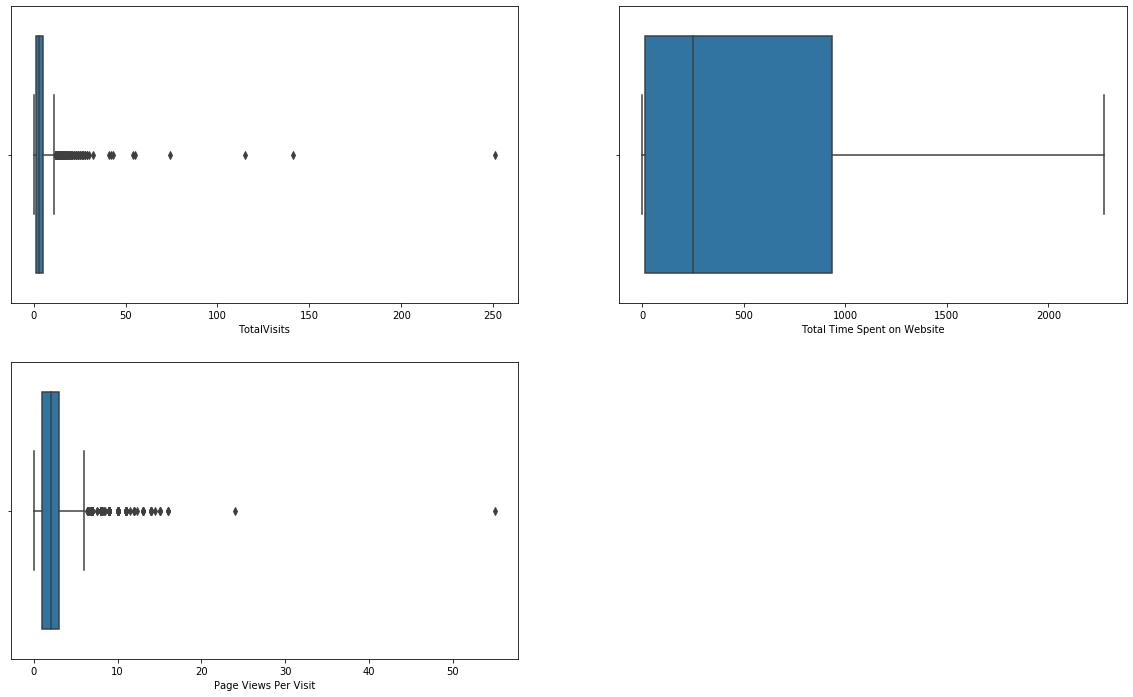

In [70]:
features = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']
# Plotting Box plot for continuous columns
plt.figure(figsize = (20,12))
for i in enumerate(features):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(df[i[1]])

##### Observation
There are lot of outliers in **TotalVisits** and **Page Views per Visit**

In [71]:
### Caping data at the 1% & 95% mark so as to not lose any values or drop rows
q1 = df['Page Views Per Visit'].quantile(0.01)
df['Page Views Per Visit'][df['Page Views Per Visit']<= q1] = q1

q3 = df['Page Views Per Visit'].quantile(0.95)
df['Page Views Per Visit'][df['Page Views Per Visit']>= q3] = q3

In [72]:
### Caping data at the 1% & 95% mark so as to not lose any values or drop rows
q1 = df['TotalVisits'].quantile(0.01)
df['TotalVisits'][df['TotalVisits']<= q1] = q1

q3 = df['TotalVisits'].quantile(0.95)
df['TotalVisits'][df['TotalVisits']>= q3] = q3

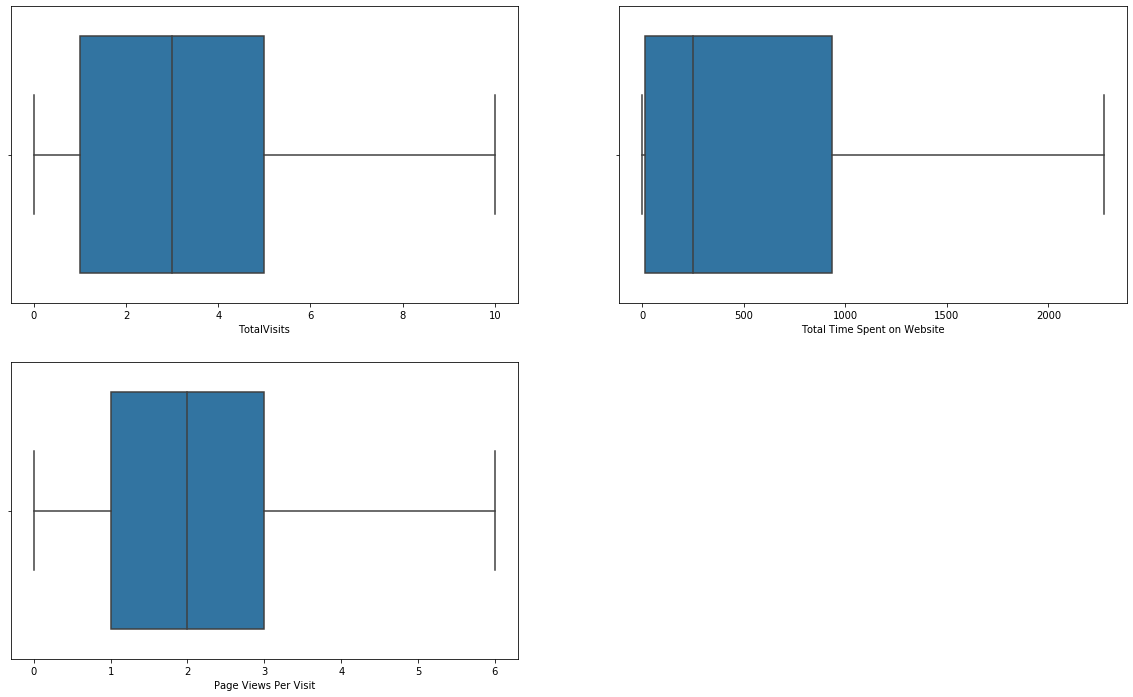

In [73]:
# Plotting Box plot for continuous columns to check after caping outliers
plt.figure(figsize = (20,12))
for i in enumerate(features):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(df[i[1]])

### Checking Categorical Variables

#### Lead Origin

In [74]:
df['Lead Origin'].value_counts()

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

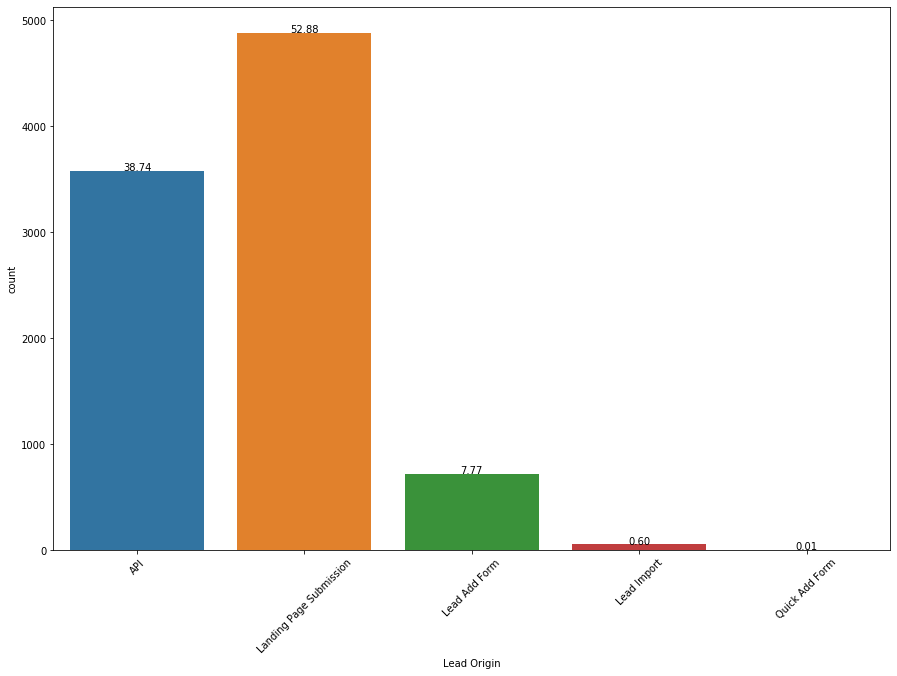

In [75]:
BarPlot(df,'Lead Origin', (15,10))

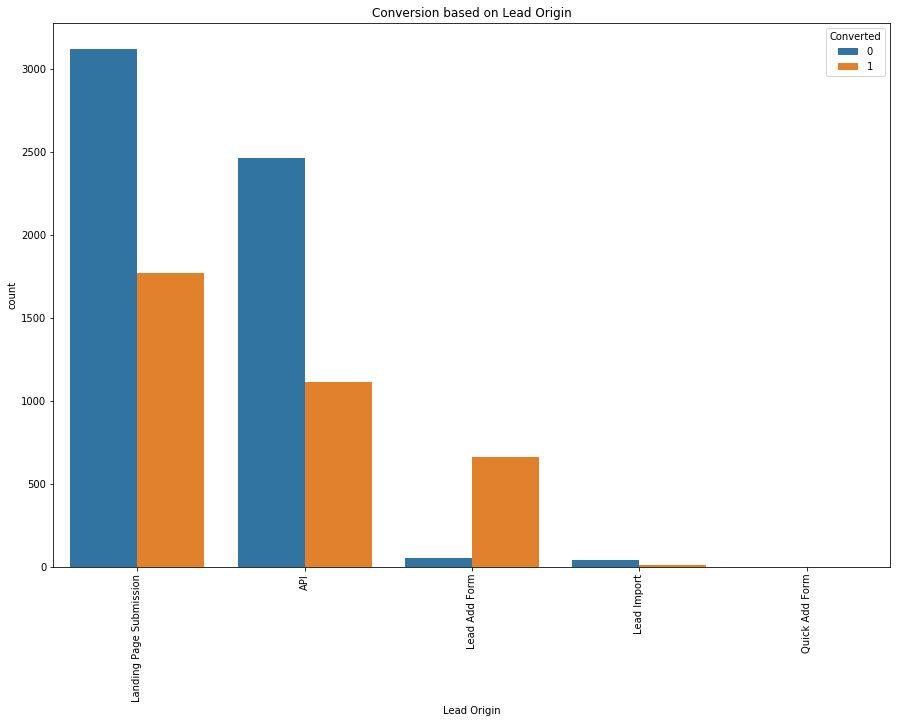

Converted                     0       1  Conversion(%)
Lead Origin                                           
Quick Add Form              0.0     1.0          100.0
Lead Add Form              54.0   664.0           92.0
Landing Page Submission  3118.0  1768.0           36.0
API                      2465.0  1115.0           31.0
Lead Import                42.0    13.0           24.0


In [76]:
CountPlot(df,'Lead Origin','Conversion based on Lead Origin',(15,10),hue='Converted')

### Observation
From the barplot above we can infer that:

- Lead Add Form has the highest conversion rate at 92%
- Quick Add Form has 100% conversion rate but it has only 1 entry, so it might not be that reliable as a lead to go on
- API has the least amount of conversions

#### Lead Source

In [77]:
df['Lead Source'].value_counts()

Google               2909
Direct traffic       2543
Olark chat           1755
Organic search       1154
Reference             534
Welingak website      142
Referral sites        125
Facebook               55
Bing                    6
Click2call              4
Press_release           2
Social media            2
Live chat               2
Welearn                 1
Youtubechannel          1
Testone                 1
Nc_edm                  1
Pay per click ads       1
Blog                    1
Welearnblog_home        1
Name: Lead Source, dtype: int64

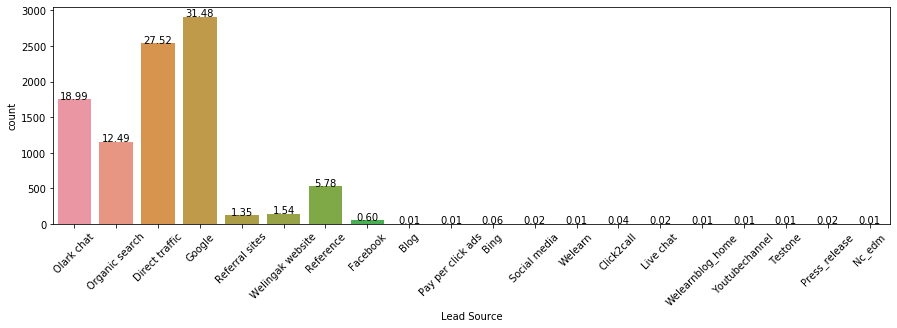

In [78]:
BarPlot(df,'Lead Source', (15,4))

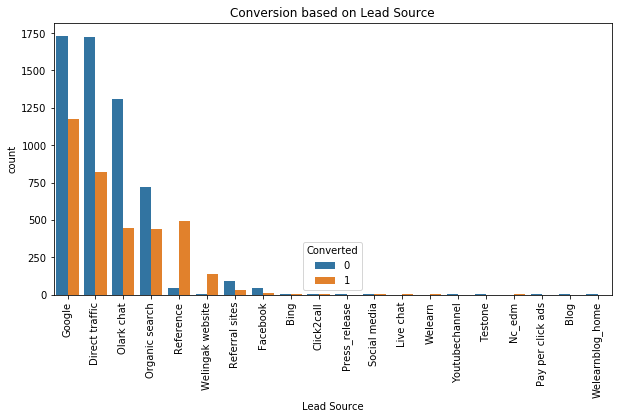

Converted               0       1  Conversion(%)
Lead Source                                     
Welearn               0.0     1.0          100.0
Live chat             0.0     2.0          100.0
Nc_edm                0.0     1.0          100.0
Welingak website      2.0   140.0           99.0
Reference            44.0   490.0           92.0
Click2call            1.0     3.0           75.0
Social media          1.0     1.0           50.0
Google             1733.0  1176.0           40.0
Organic search      718.0   436.0           38.0
Direct traffic     1725.0   818.0           32.0
Olark chat         1307.0   448.0           26.0
Referral sites       94.0    31.0           25.0
Facebook             42.0    13.0           24.0
Bing                  5.0     1.0           17.0
Welearnblog_home      1.0     0.0            0.0
Pay per click ads     1.0     0.0            0.0
Testone               1.0     0.0            0.0
Press_release         2.0     0.0            0.0
Blog                

In [79]:
CountPlot(df,'Lead Source','Conversion based on Lead Source',(10,5),hue='Converted')


#### Observations
Based on the plots above we observe that:

- Most students found X education via 'Google' search
- However, most of the google search leads weren't converted to actual students of the platform
- References had the highest number of conversions at 92%
- Welingak website also had a significantly high number of conversions at 99%
- Welearn & Nc_edm had 100% conversion but due to their low numbers overall it might not be a correct picture of the situation
- No conversions were made through the youtube channel, blog, press releases, pay per click ads or Welearnblog_home

**Note:** Let us merge the columns with low numbers into a common category: 'Others'

In [80]:
cols=['Click2call', 'Live chat', 'Nc_edm', 'Pay per click ads', 'Press_release',
  'Social media', 'Welearn', 'Bing', 'Blog', 'Testone', 'Welearnblog_home', 'Youtubechannel']
df['Lead Source'] = df['Lead Source'].replace(cols, 'Others')

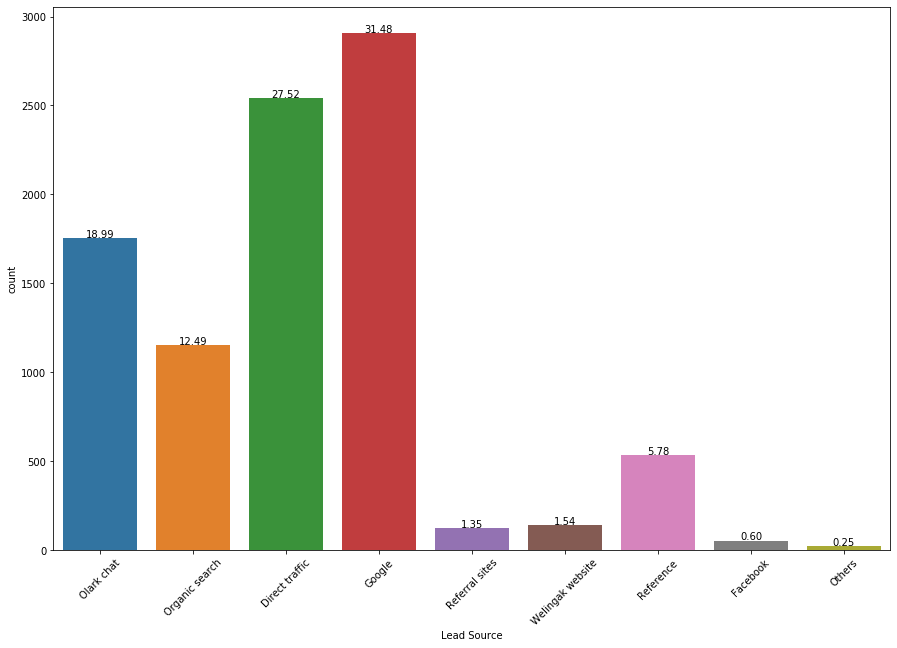

In [81]:
BarPlot(df,'Lead Source', (15,10))

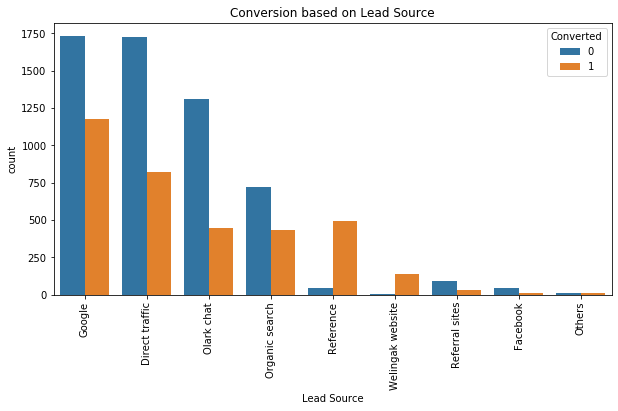

Converted            0     1  Conversion(%)
Lead Source                                
Welingak website     2   140           99.0
Reference           44   490           92.0
Google            1733  1176           40.0
Others              14     9           39.0
Organic search     718   436           38.0
Direct traffic    1725   818           32.0
Olark chat        1307   448           26.0
Referral sites      94    31           25.0
Facebook            42    13           24.0


In [82]:
CountPlot(df,'Lead Source','Conversion based on Lead Source',(10,5),hue='Converted')

#### Observation
To imporve the conversion rate X education should focus on providing incentives to referrals as well as improve the lead conversion through olark chat, organic search, direct traffic, and google leads and generate more leads from reference and welingak website.

#### Do Not Email

In [83]:
df['Do Not Email'].value_counts()

No     8506
Yes     734
Name: Do Not Email, dtype: int64

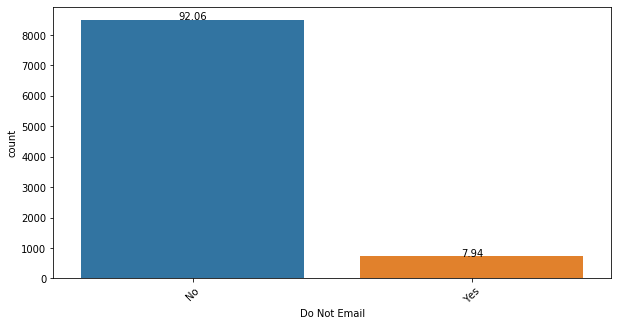

In [84]:
BarPlot(df,'Do Not Email', (10,5))

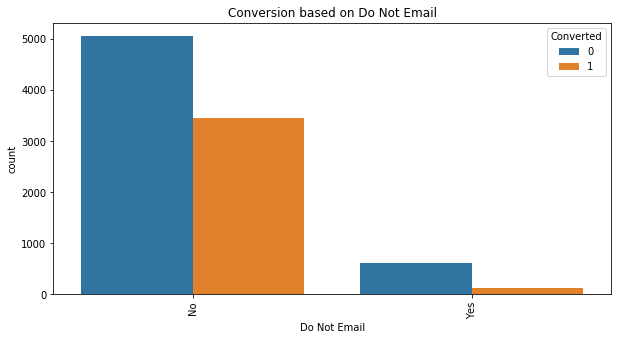

Converted        0     1  Conversion(%)
Do Not Email                           
No            5063  3443           40.0
Yes            616   118           16.0


In [85]:
CountPlot(df,'Do Not Email','Conversion based on Do Not Email',(10,5),hue='Converted')

#### Observation
Based on the above we can see that the data is highly skewed. Therefore we will be dropping this column eventually

#### Do Not Call

In [86]:
df['Do Not Call'].value_counts()

No     9238
Yes       2
Name: Do Not Call, dtype: int64

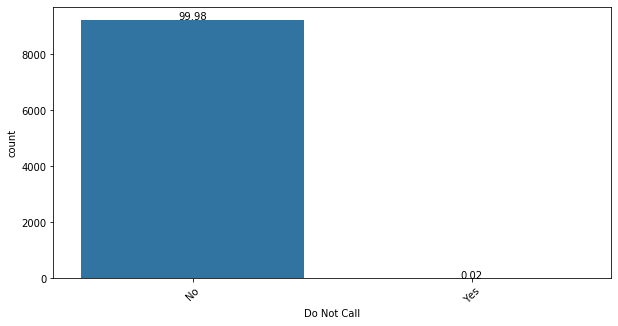

In [87]:
BarPlot(df,'Do Not Call', (10,5))

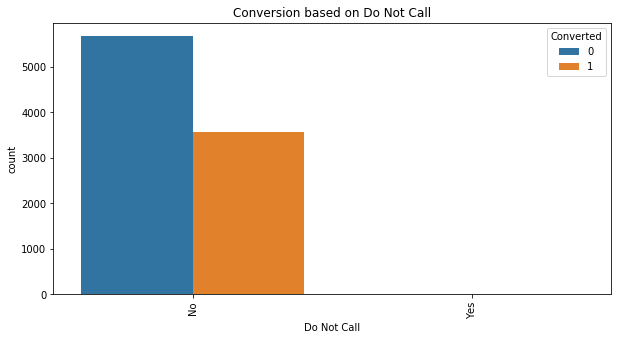

Converted         0       1  Conversion(%)
Do Not Call                               
Yes             0.0     2.0          100.0
No           5679.0  3559.0           39.0


In [88]:
CountPlot(df,'Do Not Call','Conversion based on Do Not Call',(10,5),hue='Converted')

### Observations
Based on the above we can see that the data is highly skewed. Therefore we will be dropping this column eventually

Note
We will be dropping the columns Do Not Email & Do Not Call as the data is highly skewed towards the No section. These two columns can be take as safe assumptions by company X that 99% of their prospective customers do not like to be called or receive emails.

In [89]:
df = df.drop(['Do Not Call', 'Do Not Email'], axis=1)
df.shape

(9240, 19)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 19 columns):
Lead Number                               9240 non-null int64
Lead Origin                               9240 non-null object
Lead Source                               9240 non-null object
Converted                                 9240 non-null int64
TotalVisits                               9240 non-null float64
Total Time Spent on Website               9240 non-null int64
Page Views Per Visit                      9240 non-null float64
Last Activity                             9240 non-null object
Specialization                            9240 non-null object
What is your current occupation           9240 non-null object
Search                                    9240 non-null object
Newspaper Article                         9240 non-null object
X Education Forums                        9240 non-null object
Newspaper                                 9240 non-null object
Digital Adve

#### Last Activity

In [91]:
df['Last Activity'].value_counts()

Email Opened                    3540
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

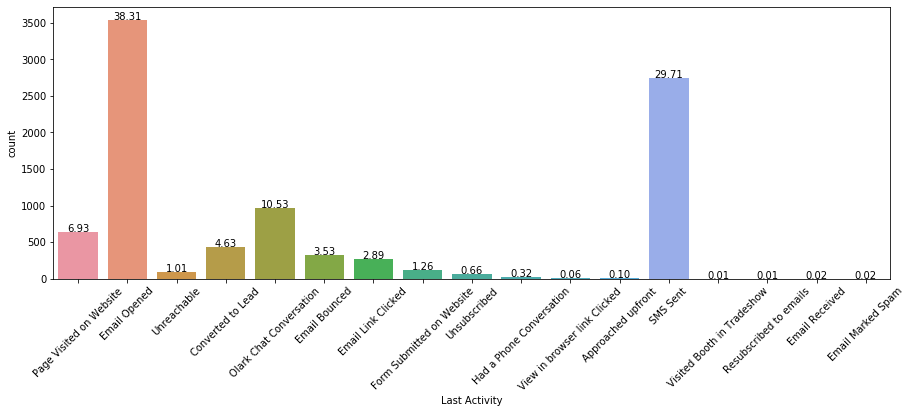

In [92]:
BarPlot(df,'Last Activity', (15,5))

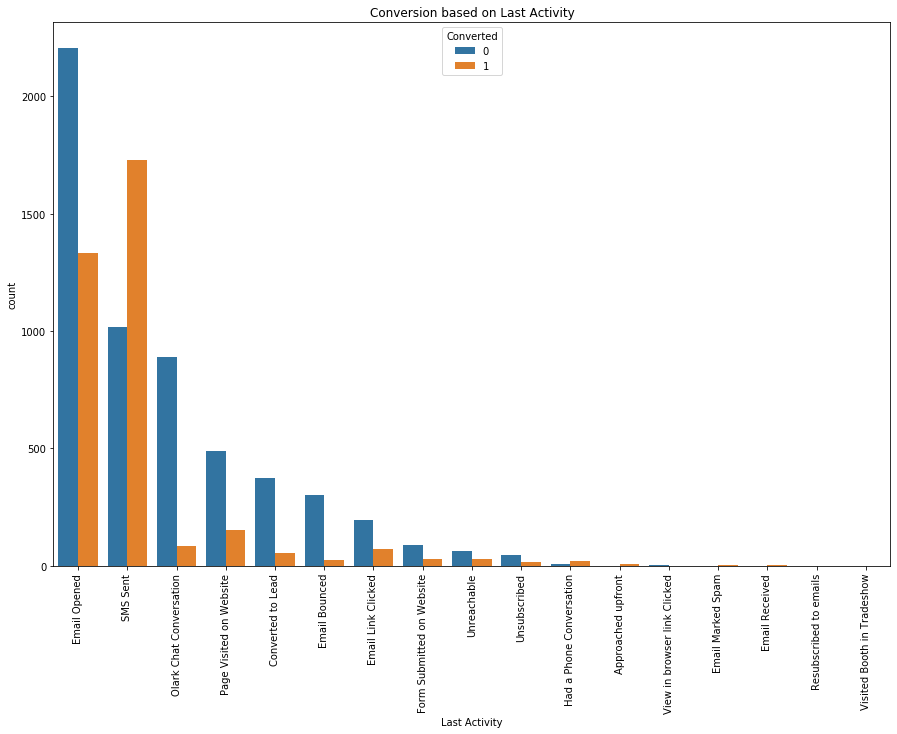

Converted                          0       1  Conversion(%)
Last Activity                                              
Approached upfront               0.0     9.0          100.0
Email Marked Spam                0.0     2.0          100.0
Resubscribed to emails           0.0     1.0          100.0
Email Received                   0.0     2.0          100.0
Had a Phone Conversation         8.0    22.0           73.0
SMS Sent                      1018.0  1727.0           63.0
Email Opened                  2206.0  1334.0           38.0
Unreachable                     62.0    31.0           33.0
Email Link Clicked             194.0    73.0           27.0
Unsubscribed                    45.0    16.0           26.0
Form Submitted on Website       88.0    28.0           24.0
Page Visited on Website        489.0   151.0           24.0
View in browser link Clicked     5.0     1.0           17.0
Converted to Lead              374.0    54.0           13.0
Olark Chat Conversation        889.0    

In [93]:
CountPlot(df,'Last Activity','Conversion based on Last Activity',(15,10),hue='Converted')

#### Observation
Based on the plots above we can infer that:

- People interacting with the portal usually send sms the most
- Only 24% of people who visit the website convert to actual students

#### Note:
**Search, Newspaper Article, Education Forums, Newspaper , Digital Advertisement and Through Recommendations**, are already represented in the 'Lead Source' column.

We will carry out basic univariate analysis on them and make a decision on if we need to drop them or not.

In [94]:
features = ['Search', 'Newspaper Article', 'X Education Forums', 'Newspaper' , 'Digital Advertisement','Through Recommendations']
for i in enumerate(features):
    print(df[i[1]].value_counts())

No     9226
Yes      14
Name: Search, dtype: int64
No     9238
Yes       2
Name: Newspaper Article, dtype: int64
No     9239
Yes       1
Name: X Education Forums, dtype: int64
No     9239
Yes       1
Name: Newspaper, dtype: int64
No     9236
Yes       4
Name: Digital Advertisement, dtype: int64
No     9233
Yes       7
Name: Through Recommendations, dtype: int64


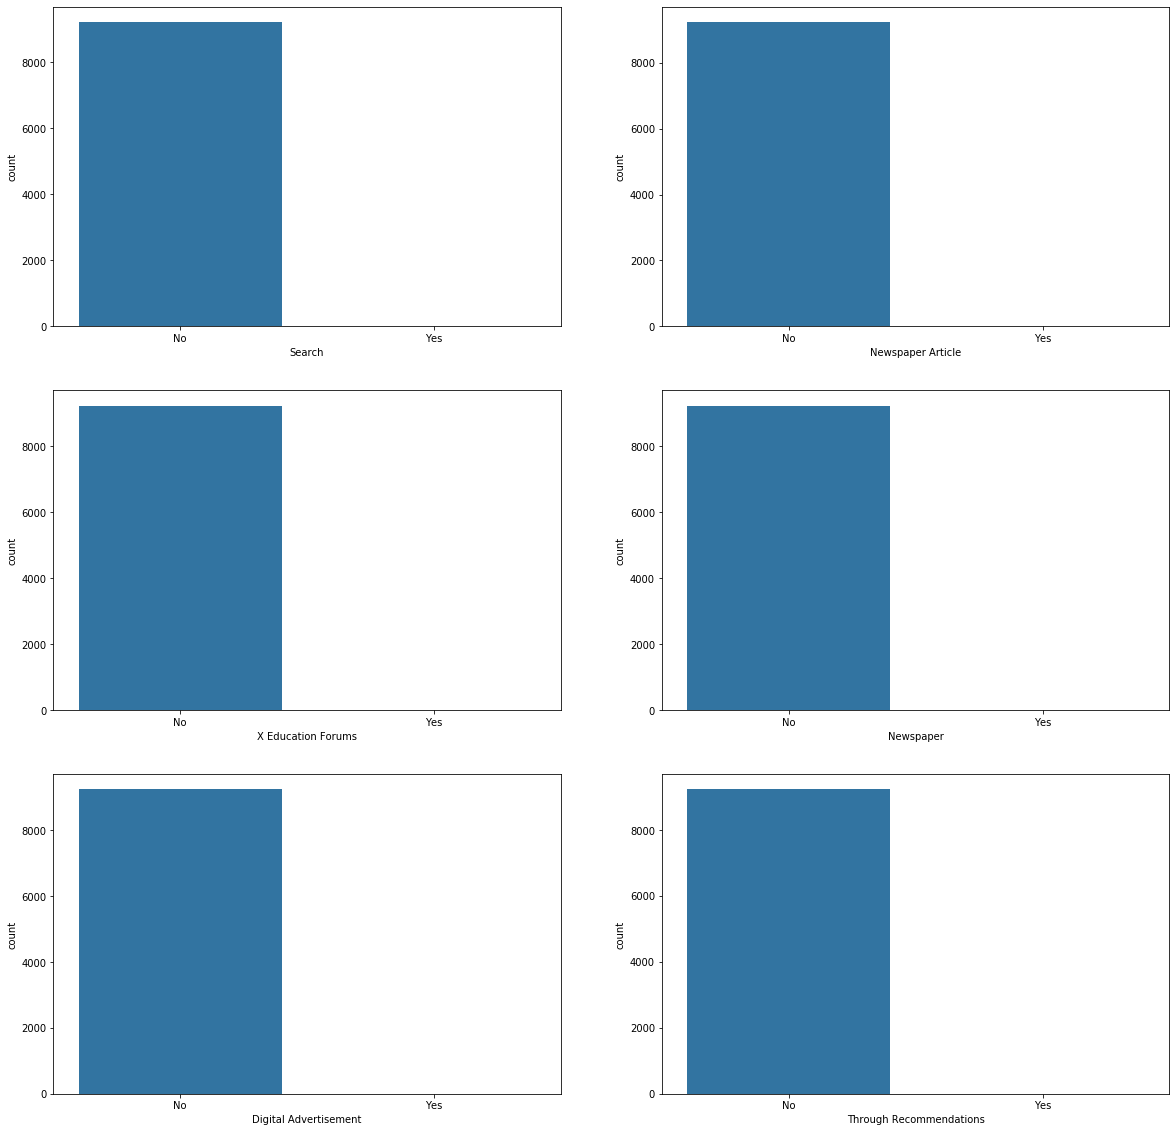

In [95]:
features = ['Search', 'Newspaper Article', 'X Education Forums', 'Newspaper' , 'Digital Advertisement','Through Recommendations']
plt.figure(figsize = (20,20))
for i in enumerate(features):
    plt.subplot(3,2,i[0]+1)
    sns.countplot(x = df[i[1]], data = df) 
plt.show()

#### Observation
The data feels highly skewed in these columns and confirms our assumption that it is correctly represented in the Lead Source Column

Since the data for these columns is already correctly represented in the 'Lead Source' column, we will drop these columns

In [96]:
Cols = ['Search', 'Newspaper', 'X Education Forums', 'Newspaper Article' , 'Digital Advertisement','Through Recommendations']
df = df.drop(Cols,axis=1)
df.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified

#### A free copy of Mastering The Interview

In [97]:
df['A free copy of Mastering The Interview'].value_counts()

No     6352
Yes    2888
Name: A free copy of Mastering The Interview, dtype: int64

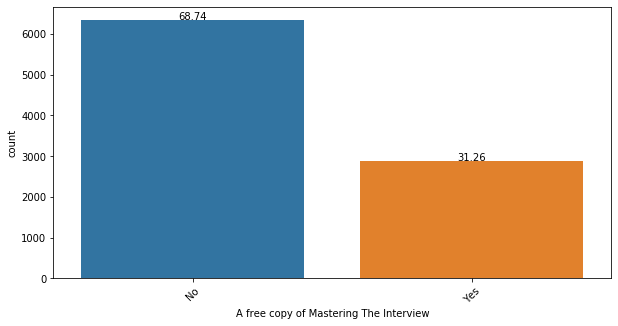

In [98]:
BarPlot(df,'A free copy of Mastering The Interview', (10,5))

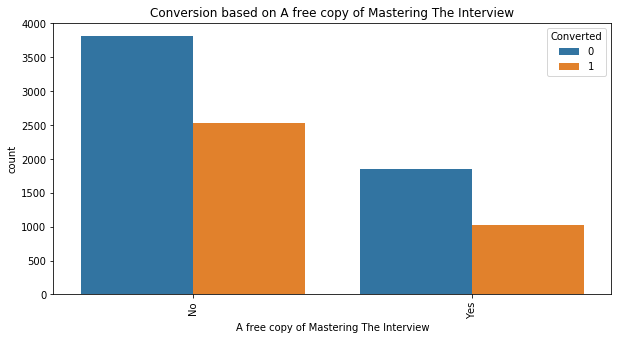

Converted                                  0     1  Conversion(%)
A free copy of Mastering The Interview                           
No                                      3821  2531           40.0
Yes                                     1858  1030           36.0


In [99]:
CountPlot(df,'A free copy of Mastering The Interview','Conversion based on A free copy of Mastering The Interview',(10,5),hue='Converted')

#### Observation
A large number of candidates, 64% didnt opt for any course even though the would like a free copy. 60% of the candidates didn't opt for any course or the free book.

### Last Notable Activity 

In [100]:
df['Last Notable Activity'].value_counts()

Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Resubscribed to emails             1
Approached upfront                 1
Email Received                     1
View in browser link Clicked       1
Form Submitted on Website          1
Name: Last Notable Activity, dtype: int64

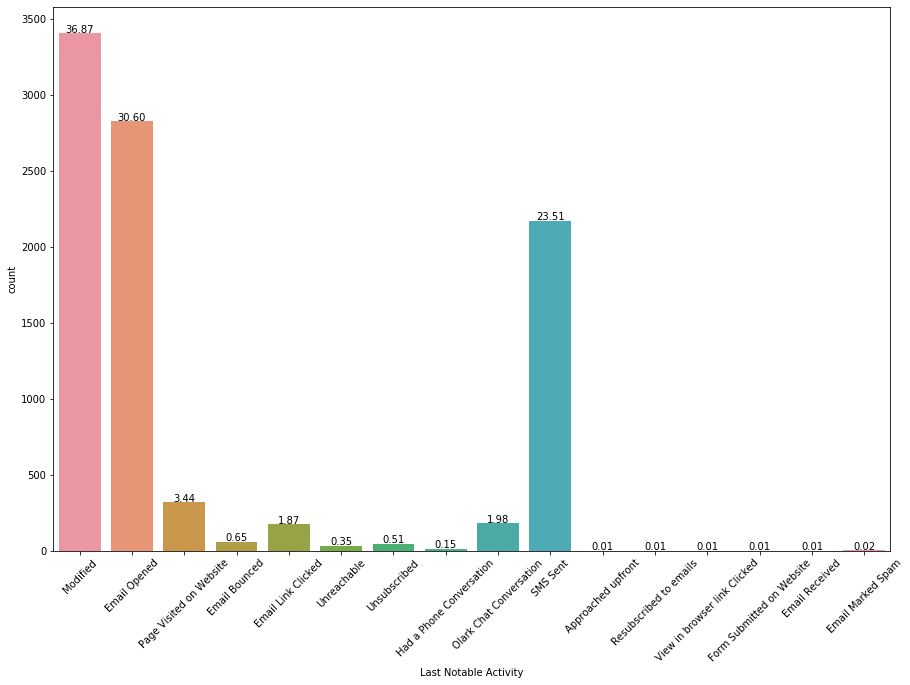

In [101]:
BarPlot(df,'Last Notable Activity', (15,10))

#### Observation
From our analysis we see that this column holds similar data represented in the **Last Activity column**. We will drop this one and keep the Last Activity column.

In [102]:
## Droping Last Notable Activity 
df= df.drop(['Last Notable Activity'], axis=1)
df.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

In [103]:
df.shape

(9240, 12)

### Specialization

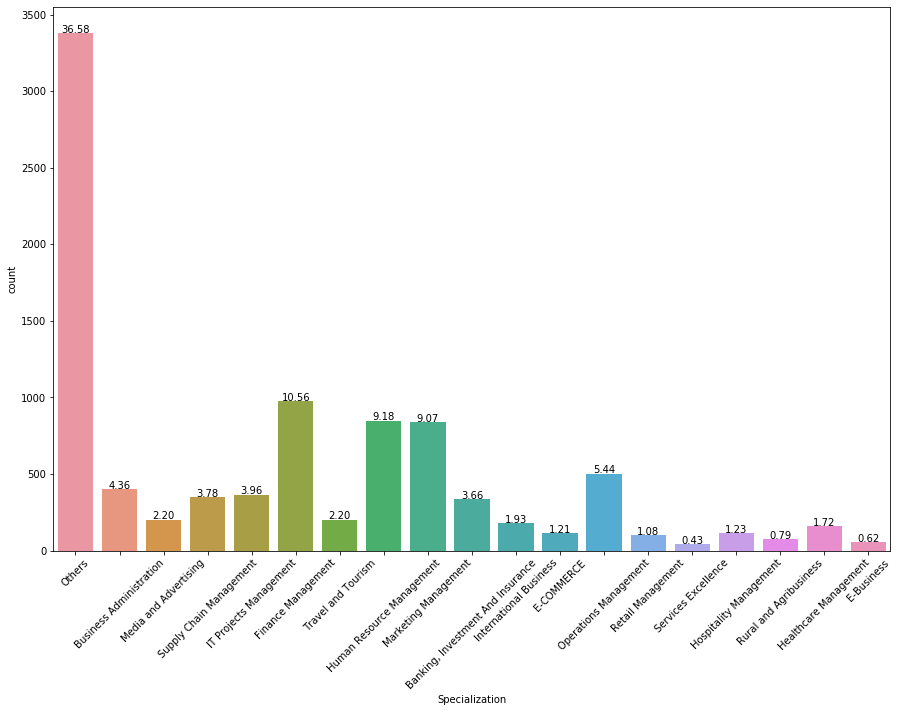

In [104]:
BarPlot(df,'Specialization', (15,10))

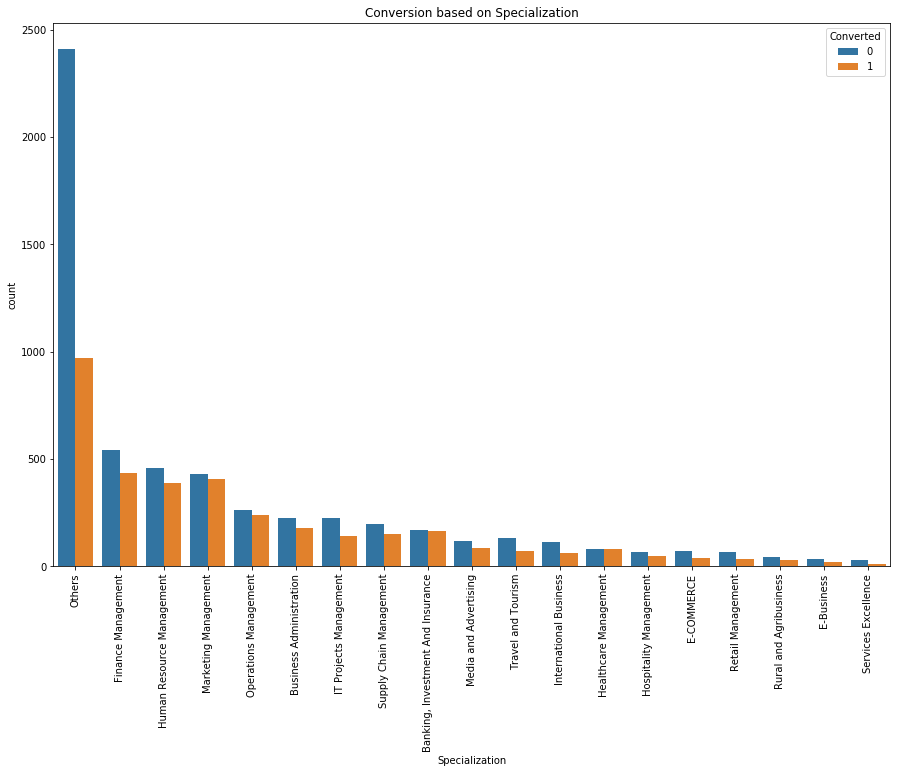

Converted                             0    1  Conversion(%)
Specialization                                             
Healthcare Management                80   79           50.0
Banking, Investment And Insurance   171  167           49.0
Marketing Management                430  408           49.0
Operations Management               265  238           47.0
Human Resource Management           460  388           46.0
Finance Management                  540  436           45.0
Business Administration             224  179           44.0
Supply Chain Management             198  151           43.0
Rural and Agribusiness               42   31           42.0
Hospitality Management               66   48           42.0
Media and Advertising               118   85           42.0
IT Projects Management              226  140           38.0
E-Business                           36   21           37.0
International Business              114   64           36.0
E-COMMERCE                           72 

In [105]:
CountPlot(df,'Specialization','Conversion based on Specialization',(15,10),hue='Converted')

#### Observation
- Healthcare Management specialization is having 50% conversion rate
- Finance Management specialization is having 45% conversion rate

### City

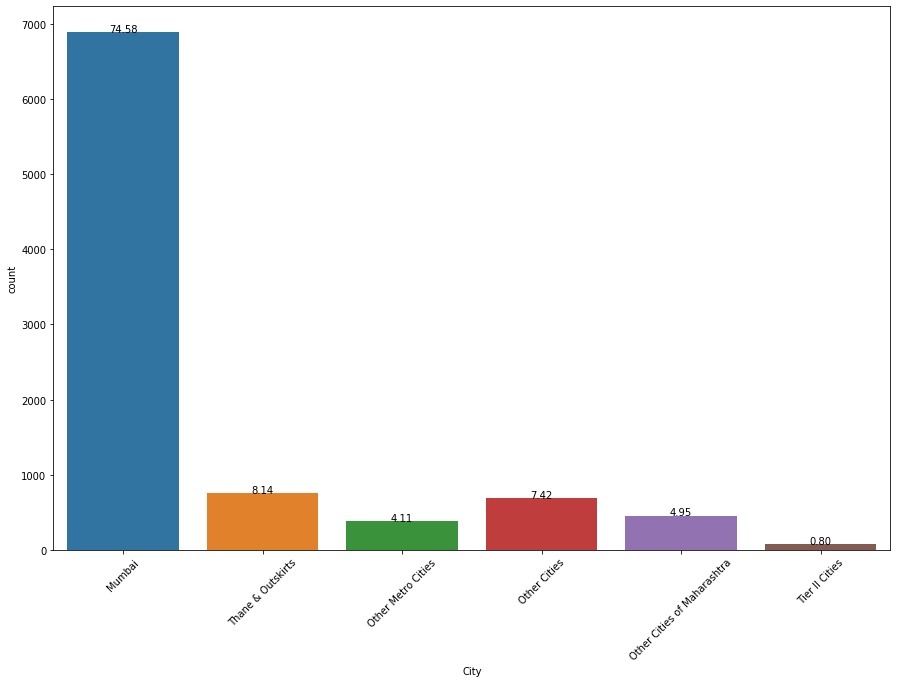

In [106]:
BarPlot(df,'City', (15,10))

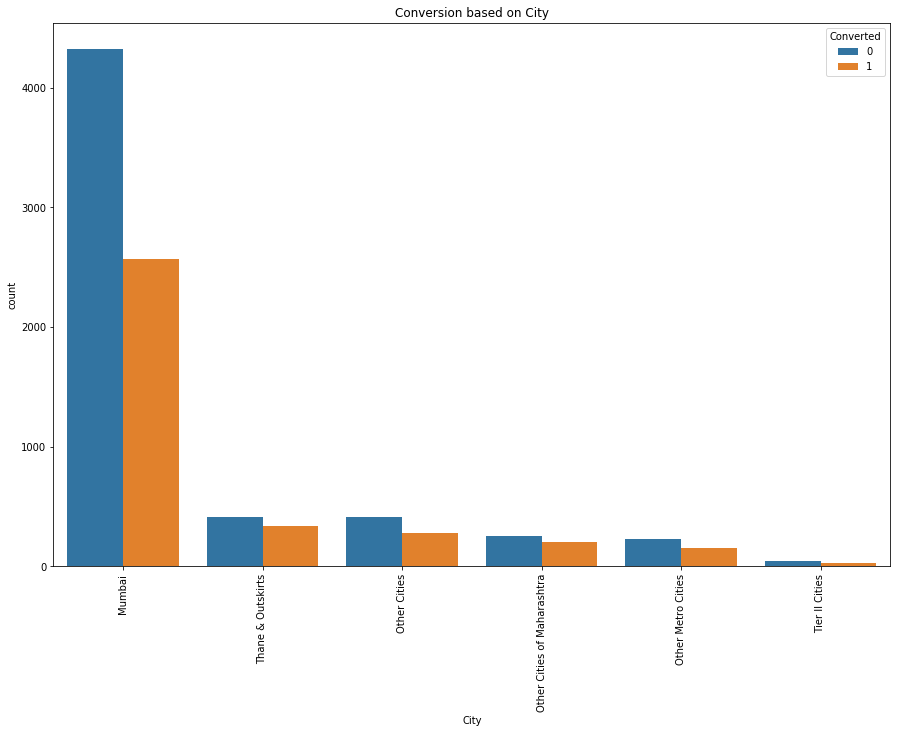

Converted                       0     1  Conversion(%)
City                                                  
Thane & Outskirts             414   338           45.0
Other Cities of Maharashtra   256   201           44.0
Other Metro Cities            225   155           41.0
Other Cities                  410   276           40.0
Mumbai                       4325  2566           37.0
Tier II Cities                 49    25           34.0


In [107]:
CountPlot(df,'City','Conversion based on City',(15,10),hue='Converted')

#### Observation
- Mumbai is having 37% Conversion rate

### What is your current occupation

In [108]:
df['What is your current occupation'].value_counts()

Unemployed              8290
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

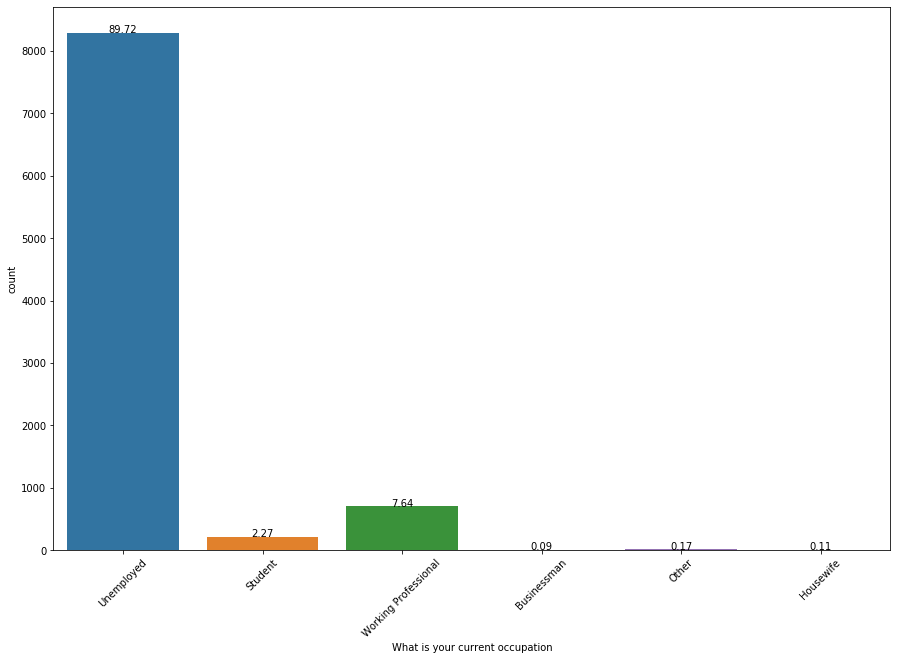

In [109]:
BarPlot(df,'What is your current occupation', (15,10))

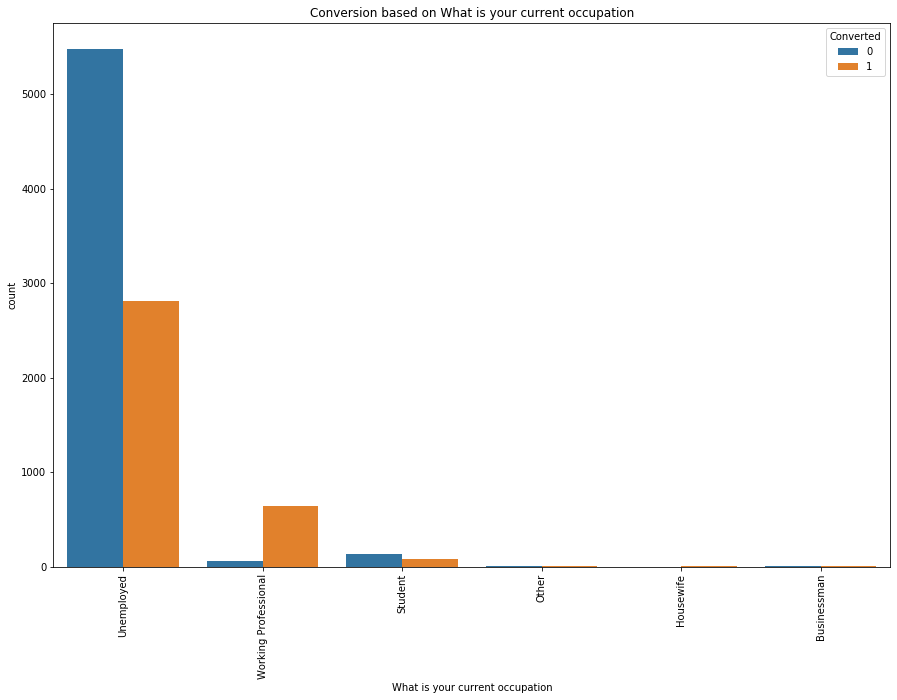

Converted                             0       1  Conversion(%)
What is your current occupation                               
Housewife                           0.0    10.0          100.0
Working Professional               59.0   647.0           92.0
Businessman                         3.0     5.0           62.0
Other                               6.0    10.0           62.0
Student                           132.0    78.0           37.0
Unemployed                       5479.0  2811.0           34.0


In [110]:
CountPlot(df,'What is your current occupation','Conversion based on What is your current occupation',(15,10),hue='Converted')

#### Observation
- Housewife are having 100% Conversion rate but their count are very less
- Unemployed are having 34% Conversion rate
- Student are having 37% Conversion rate
- Working professionals are having 92% conversion rate

### Checking Continuous Variables

#### Total  Visit

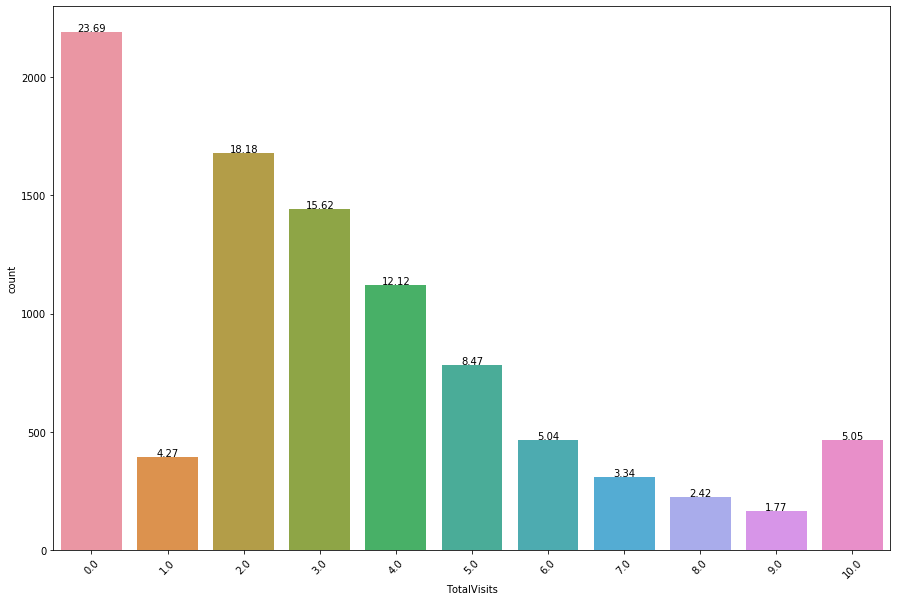

In [111]:
BarPlot(df,'TotalVisits', (15,10))

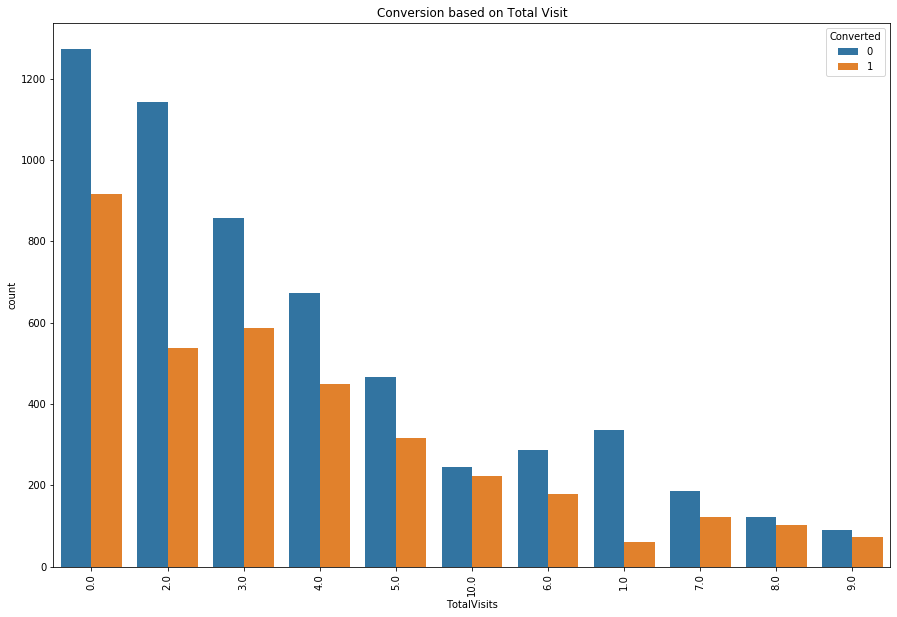

Converted       0    1  Conversion(%)
TotalVisits                          
10.0          245  222           48.0
8.0           121  103           46.0
9.0            91   73           45.0
0.0          1273  916           42.0
3.0           857  586           41.0
4.0           672  448           40.0
5.0           467  316           40.0
7.0           187  122           39.0
6.0           288  178           38.0
2.0          1143  537           32.0
1.0           335   60           15.0


In [112]:
CountPlot(df,'TotalVisits','Conversion based on Total Visit',(15,10),hue='Converted')

### Observations
From the above analysis we can conclude that:

- People who make more than 10 visits are almost 50% likely to be converted
- Only 15% of people who visited the website once converted to student. This could imply that people weren't able to gather all the information they needed easily. Hence, decided not to opt for any course.

#### Total Time Spent on Website

#### Page Views Per Visit  

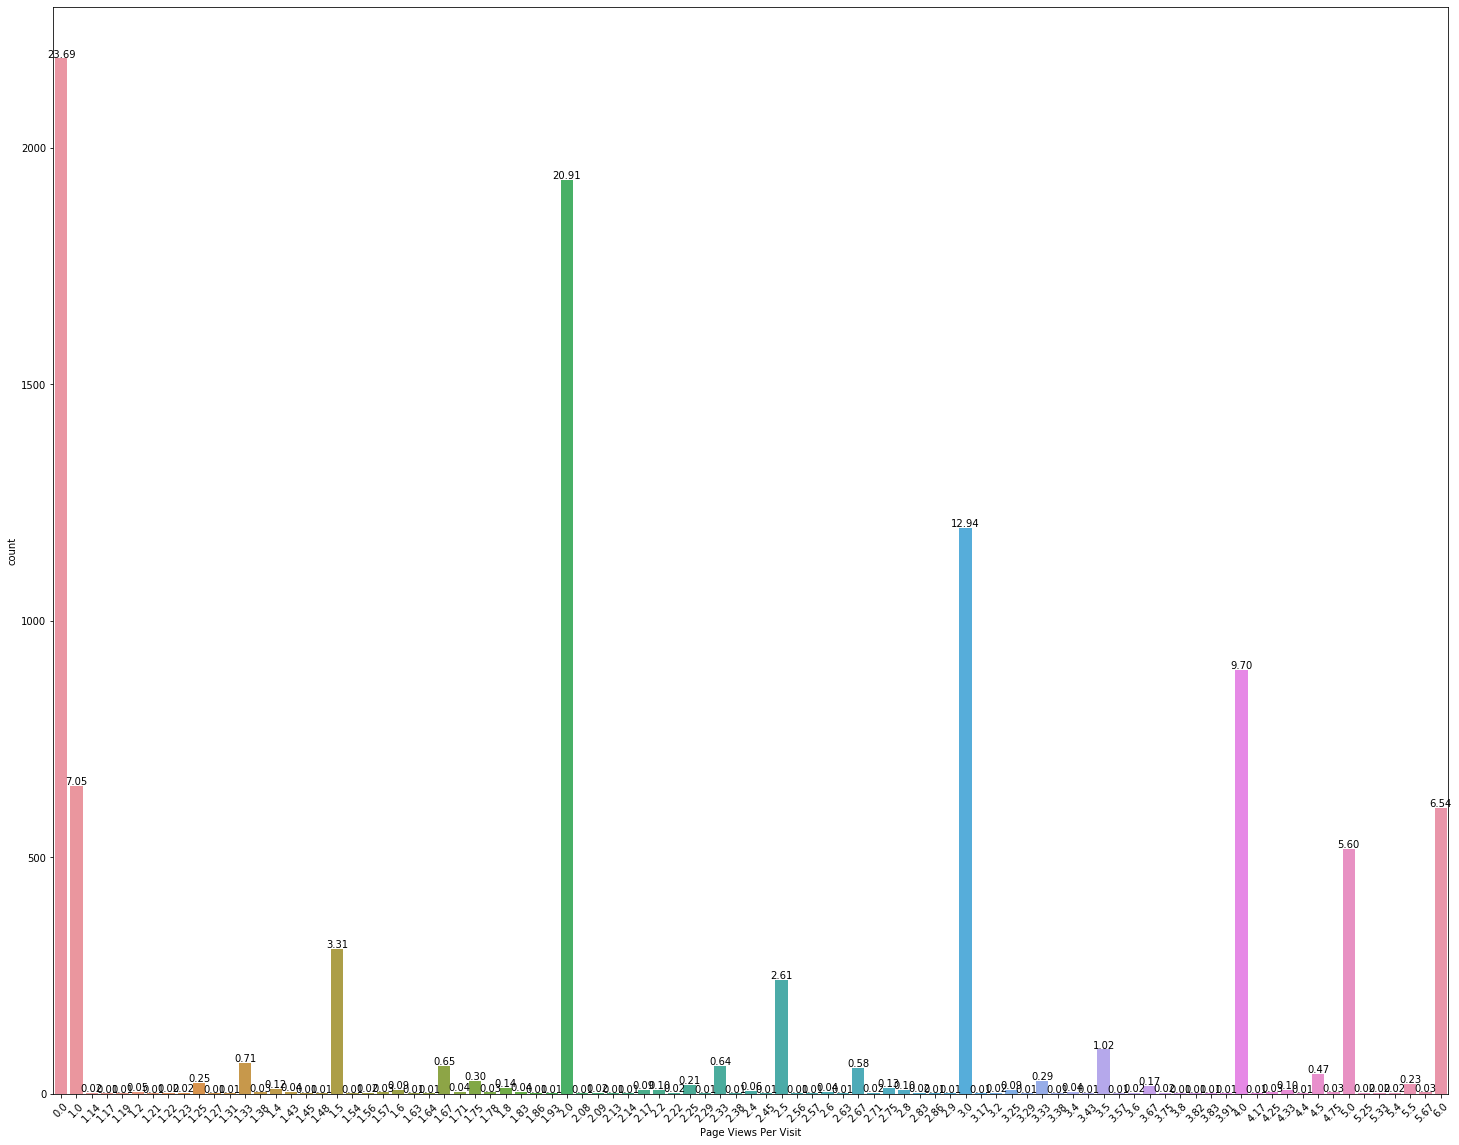

In [113]:
BarPlot(df,'Page Views Per Visit', (25,20))

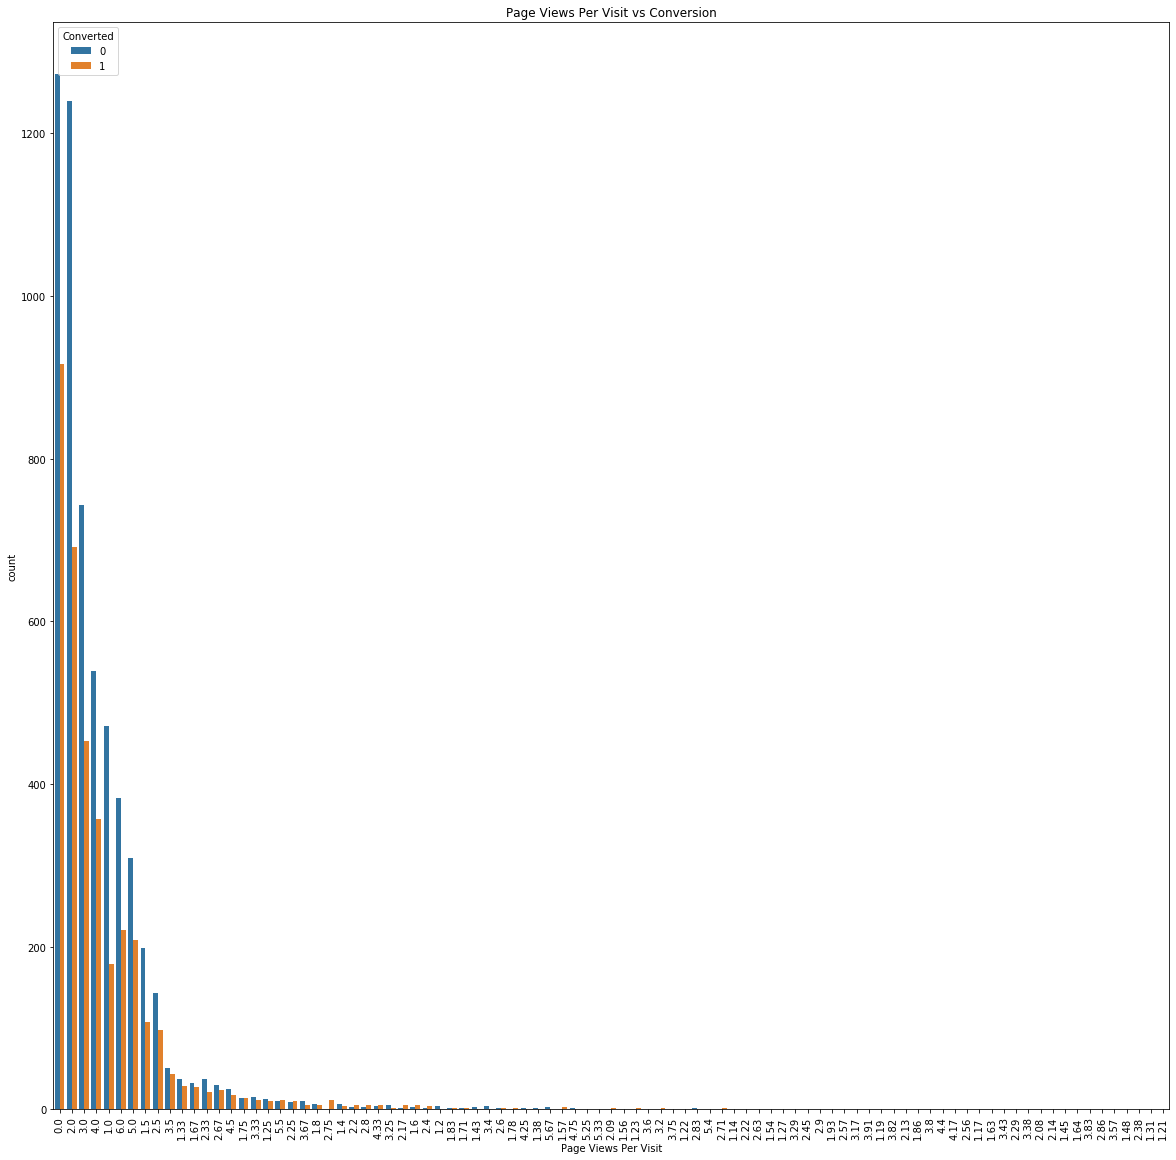

Converted               0    1  Conversion(%)
Page Views Per Visit                         
2.63                  0.0  1.0          100.0
3.29                  0.0  1.0          100.0
1.64                  0.0  1.0          100.0
1.63                  0.0  1.0          100.0
1.93                  0.0  1.0          100.0
...                   ...  ...            ...
3.57                  1.0  0.0            0.0
2.13                  1.0  0.0            0.0
3.40                  4.0  0.0            0.0
3.38                  1.0  0.0            0.0
2.56                  1.0  0.0            0.0

[91 rows x 3 columns]


In [114]:
CountPlot(df,'Page Views Per Visit','Page Views Per Visit vs Conversion',(20,20),hue='Converted')

### Observation
From the above plots it is safe to infer that:

- People who dont visit any pages have the highest count of conversion overall
- Less than half the people who visit 2 pages on average convert to students

#### Total Time Spent on Website

In [115]:
df['Total Time Spent on Website'].value_counts()

0       2193
60        19
127       18
75        18
74        18
        ... 
1235       1
1091       1
1043       1
1035       1
1915       1
Name: Total Time Spent on Website, Length: 1731, dtype: int64

#### Observation
The above looks like time spent was recorded in minutes. We will convert the entire column into hours for ease of analysis

In [116]:
df['Total Time Spent on Website'] = df['Total Time Spent on Website'].apply(lambda x: round((x/60), 2))
df.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

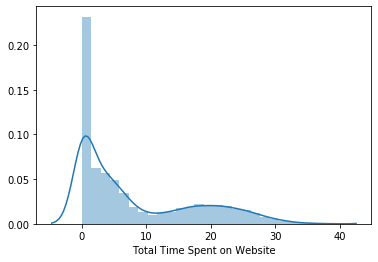

In [117]:
sns.distplot(df['Total Time Spent on Website'])
plt.show()

In [118]:
# Let us split our dataframe to perform better analysis
df1=df[df['Total Time Spent on Website']>=1.0]
df1["Hours Spent"]= df1["Total Time Spent on Website"].astype(int)

df1.head()

Lead Number              Lead Origin     Lead Source  Converted  \
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   
6       660673  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   
6          2.0                        27.33                   2.0   

       Last Activity           Specialization What is your current occupation  \
1       Email Opened                   Others                      Unemployed   
2       Email Opened  Business Administration                         Student   
3        Unreachable    Media and Advertising                      Unemployed   
4  Converted to Lead                   Others                      Unemployed   
6       Email Opened  Supply Chain Management                      Unemployed   

     City A free copy of Mastering The Interview  Hours Spent  
1  Mumbai                                     No           11  
2  Mumbai                                    Yes           25  
3  Mumbai                                     No            5  
4  Mumbai                                     No           23  
6  Mumbai                                     No           27

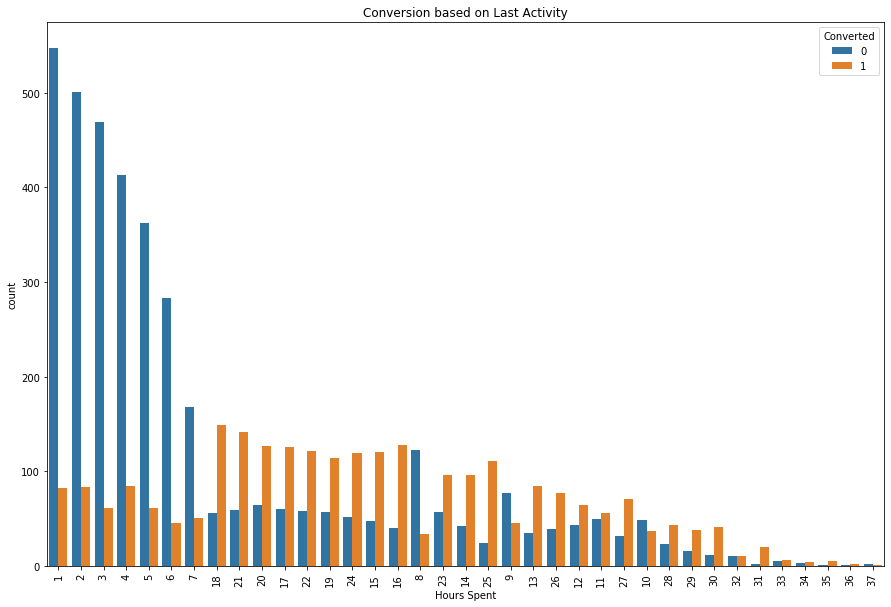

Converted      0    1  Conversion(%)
Hours Spent                         
31             2   20           91.0
35             1    5           83.0
25            24  111           82.0
30            12   41           77.0
16            40  128           76.0
18            56  149           73.0
15            48  121           72.0
21            59  142           71.0
13            35   85           71.0
24            52  119           70.0
14            42   96           70.0
29            16   38           70.0
27            32   71           69.0
22            58  122           68.0
17            60  126           68.0
19            57  114           67.0
36             1    2           67.0
20            64  127           66.0
26            39   77           66.0
28            23   43           65.0
23            57   96           63.0
12            43   64           60.0
34             3    4           57.0
33             5    6           55.0
11            50   56           53.0
3

In [119]:
CountPlot(df1,'Hours Spent','Conversion based on Last Activity',(15,10),hue='Converted')

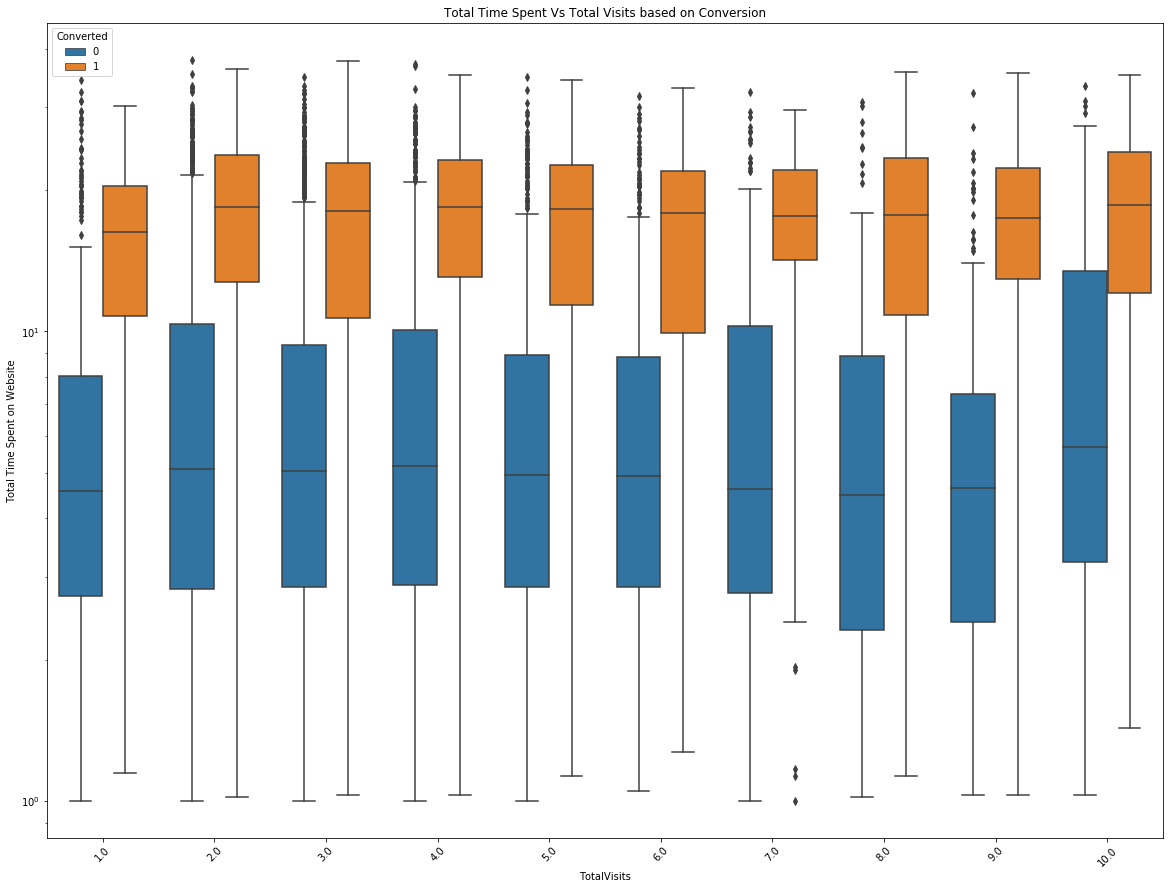

In [120]:
plt.figure(figsize=(20,15))
plt.xticks(rotation=45)
plt.yscale('log')
sns.boxplot(data =df1, x='TotalVisits',y='Total Time Spent on Website', hue ='Converted',orient='v')
plt.title('Total Time Spent Vs Total Visits based on Conversion')
plt.show()

### Observation
From the above bar plot we can infer that:

- The highest number of conversions happen when people are spending around 18 hours or above on the website
- People who spent around 3 hours on the website didn't opt for any courses.
- From the boxplot we can see better that the longer you stay on the website, the higher your chances of conversion as well.
 
 Overall more time the user spends on the website, the better their chances of becoming a student.

### Checking  Corelation b/w Variables

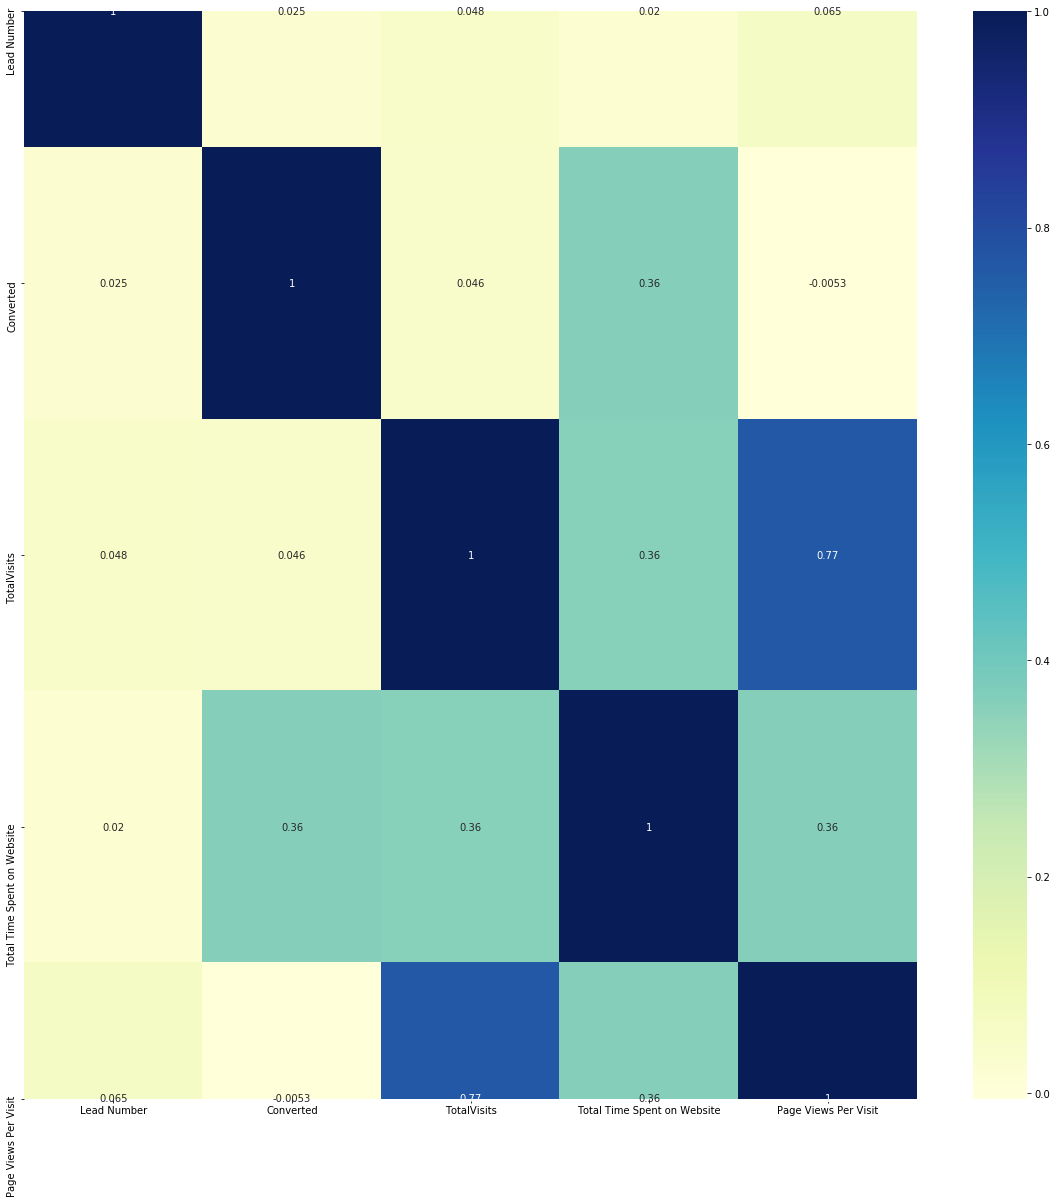

In [121]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='YlGnBu',annot=True)

#### Observation
Based on the above heatmap we can see that we don't have any highly correlated features. Therefore there is no multicollinearity in the dataset.

In [122]:
# Final Dataframe
df.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

## Step 4 Data Preparation

### Creating Dummy Values

In [123]:
### First we will convert the Yes/No values in the 'A free copy of Mastering The Interview' column to 1/0

df['A free copy of Mastering The Interview'] = df['A free copy of Mastering The Interview'].map(dict(Yes=1, No=0))
df.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation    City  \
0                      Unemployed  Mumbai   
1                      Unemployed  Mumbai   
2                         Student  Mumbai   
3                      Unemployed  Mumbai   
4                      Unemployed  Mumbai   

   A free copy of Mastering The Interview  
0                                       0  
1                                       0  
2                                       1  
3                                       0  
4                                       0

In [124]:
dummy_Cols = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation','City']
dummy = pd.get_dummies(df[dummy_Cols],drop_first=True)
dummy.head()

Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_Facebook  \
0                        0                           0                     0   
1                        0                           0                     0   
2                        0                           0                     0   
3                        0                           0                     0   
4                        0                           0                     0   

   Lead Source_Google  Lead Source_Olark chat  Lead Source_Organic search  \
0                   0                       1                           0   
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   

   Lead Source_Others  Lead Source_Reference  ...  \
0                   0                      0  ...   
1                   0                      0  ...   
2                   0                      0  ...   
3                   0                      0  ...   
4                   0                      0  ...   

   What is your current occupation_Housewife  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   What is your current occupation_Other  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   What is your current occupation_Student  \
0                                        0   
1                                        0   
2                                        1   
3                                        0   
4                                        0   

   What is your current occupation_Unemployed  \
0                                           1   
1                                           1   
2                                           0   
3                                           1   
4                                           1   

   What is your current occupation_Working Professional  City_Other Cities  \
0                                                  0                     0   
1                                                  0                     0   
2                                                  0                     0   
3                                                  0                     0   
4                                                  0                     0   

   City_Other Cities of Maharashtra  City_Other Metro Cities  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   

   City_Thane & Outskirts  City_Tier II Cities  
0                       0                    0  
1                       0                    0  
2                       0                    0  
3                       0                    0  
4                       0                    0  

[5 rows x 56 columns]

In [125]:
combined = df.copy()
combined.shape

(9240, 12)

In [126]:
combined = pd.concat([combined, dummy], axis=1)
combined.head()

Lead Number              Lead Origin     Lead Source  Converted  \
0       660737                      API      Olark chat          0   
1       660728                      API  Organic search          0   
2       660727  Landing Page Submission  Direct traffic          1   
3       660719  Landing Page Submission  Direct traffic          0   
4       660681  Landing Page Submission          Google          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                   Others   
1             Email Opened                   Others   
2             Email Opened  Business Administration   
3              Unreachable    Media and Advertising   
4        Converted to Lead                   Others   

  What is your current occupation  ...  \
0                      Unemployed  ...   
1                      Unemployed  ...   
2                         Student  ...   
3                      Unemployed  ...   
4                      Unemployed  ...   

  What is your current occupation_Housewife  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   What is your current occupation_Other  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   What is your current occupation_Student  \
0                                        0   
1                                        0   
2                                        1   
3                                        0   
4                                        0   

   What is your current occupation_Unemployed  \
0                                           1   
1                                           1   
2                                           0   
3                                           1   
4                                           1   

   What is your current occupation_Working Professional  City_Other Cities  \
0                                                  0                     0   
1                                                  0                     0   
2                                                  0                     0   
3                                                  0                     0   
4                                                  0                     0   

   City_Other Cities of Maharashtra  City_Other Metro Cities  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   

   City_Thane & Outskirts  City_Tier II Cities  
0                       0                    0  
1                       0                    0  
2                       0                    0  
3                       0                    0  
4                       0                    0  

[5 rows x 68 columns]

In [127]:
### We will now drop the original columns and the columns that have 'Others' as a sub heading since we had 
### combined various values to create those columns

cols = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation','City',
                     'Lead Source_Others','Specialization_Others']
combined = combined.drop(cols, axis=1)
combined.head()

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0       660737          0          0.0                         0.00   
1       660728          0          5.0                        11.23   
2       660727          1          2.0                        25.53   
3       660719          0          1.0                         5.08   
4       660681          1          2.0                        23.80   

   Page Views Per Visit  A free copy of Mastering The Interview  \
0                   0.0                                       0   
1                   2.5                                       0   
2                   2.0                                       1   
3                   1.0                                       0   
4                   1.0                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  ...  \
0                        0                           0  ...   
1                        0                           0  ...   
2                        0                           0  ...   
3                        0                           0  ...   
4                        0                           0  ...   

   What is your current occupation_Housewife  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   What is your current occupation_Other  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   What is your current occupation_Student  \
0                                        0   
1                                        0   
2                                        1   
3                                        0   
4                                        0   

   What is your current occupation_Unemployed  \
0                                           1   
1                                           1   
2                                           0   
3                                           1   
4                                           1   

   What is your current occupation_Working Professional  City_Other Cities  \
0                                                  0                     0   
1                                                  0                     0   
2                                                  0                     0   
3                                                  0                     0   
4                                                  0                     0   

   City_Other Cities of Maharashtra  City_Other Metro Cities  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   

   City_Thane & Outskirts  City_Tier II Cities  
0                       0                    0  
1                       0                    0  
2                       0                    0  
3                       0                    0  
4                       0                    0  

[5 rows x 60 columns]

In [128]:
combined.shape

(9240, 60)

In [129]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 60 columns):
Lead Number                                             9240 non-null int64
Converted                                               9240 non-null int64
TotalVisits                                             9240 non-null float64
Total Time Spent on Website                             9240 non-null float64
Page Views Per Visit                                    9240 non-null float64
A free copy of Mastering The Interview                  9240 non-null int64
Lead Origin_Landing Page Submission                     9240 non-null uint8
Lead Origin_Lead Add Form                               9240 non-null uint8
Lead Origin_Lead Import                                 9240 non-null uint8
Lead Origin_Quick Add Form                              9240 non-null uint8
Lead Source_Facebook                                    9240 non-null uint8
Lead Source_Google                                 

### Performing Train - Test Split

In [130]:
### First we will drop the Converted & Lead Number columns 
X = combined.drop(['Converted','Lead Number'], axis=1)
X.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                         0.00                   0.0   
1          5.0                        11.23                   2.5   
2          2.0                        25.53                   2.0   
3          1.0                         5.08                   1.0   
4          2.0                        23.80                   1.0   

   A free copy of Mastering The Interview  \
0                                       0   
1                                       0   
2                                       1   
3                                       0   
4                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  Lead Source_Facebook  \
0                        0                           0                     0   
1                        0                           0                     0   
2                        0                           0                     0   
3                        0                           0                     0   
4                        0                           0                     0   

   Lead Source_Google  ...  What is your current occupation_Housewife  \
0                   0  ...                                          0   
1                   0  ...                                          0   
2                   0  ...                                          0   
3                   0  ...                                          0   
4                   1  ...                                          0   

   What is your current occupation_Other  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   What is your current occupation_Student  \
0                                        0   
1                                        0   
2                                        1   
3                                        0   
4                                        0   

   What is your current occupation_Unemployed  \
0                                           1   
1                                           1   
2                                           0   
3                                           1   
4                                           1   

   What is your current occupation_Working Professional  City_Other Cities  \
0                                                  0                     0   
1                                                  0                     0   
2                                                  0                     0   
3                                                  0                     0   
4                                                  0                     0   

   City_Other Cities of Maharashtra  City_Other Metro Cities  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   

   City_Thane & Outskirts  City_Tier II Cities  
0                       0                    0  
1                       0                    0  
2                       0                    0  
3                       0                    0  
4                       0                    0

In [131]:
X.shape

(9240, 58)

In [132]:
### Adding the target variable 'Converted' to y
y = combined['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [133]:
# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [134]:
X_train.shape

(6468, 58)

In [135]:
X_test.shape

(2772, 58)

In [136]:
X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1871          0.0                         0.00                  0.00   
6795          4.0                         8.12                  1.33   
3516          5.0                         1.77                  2.50   
8105          5.0                        20.50                  5.00   
3934          0.0                         0.00                  0.00   

      A free copy of Mastering The Interview  \
1871                                       0   
6795                                       1   
3516                                       0   
8105                                       0   
3934                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1871                                    0                          0   
6795                                    1                          0   
3516                                    0                          0   
8105                                    1                          0   
3934                                    0                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
1871                        0                           0   
6795                        0                           0   
3516                        0                           0   
8105                        0                           0   
3934                        0                           0   

      Lead Source_Facebook  Lead Source_Google  ...  \
1871                     0                   0  ...   
6795                     0                   0  ...   
3516                     0                   0  ...   
8105                     0                   1  ...   
3934                     0                   0  ...   

      What is your current occupation_Housewife  \
1871                                          0   
6795                                          0   
3516                                          0   
8105                                          0   
3934                                          0   

      What is your current occupation_Other  \
1871                                      0   
6795                                      0   
3516                                      0   
8105                                      0   
3934                                      0   

      What is your current occupation_Student  \
1871                                        0   
6795                                        0   
3516                                        0   
8105                                        0   
3934                                        0   

      What is your current occupation_Unemployed  \
1871                                           1   
6795                                           1   
3516                                           1   
8105                                           1   
3934                                           1   

      What is your current occupation_Working Professional  City_Other Cities  \
1871                                                  0                     0   
6795                                                  0                     1   
3516                                                  0                     0   
8105                                                  0                     0   
3934                                                  0                     0   

      City_Other Cities of Maharashtra  City_Other Metro Cities  \
1871                                 0                        0   
6795                                 0                        0   
3516                                 0                        0   
8105                                 0                        0   
3934                                 0                        0   

      City_Thane & Outskirts  City_Tier II Cities  
1871         

In [137]:
X_train.shape

(6468, 58)

### Scaling

In [138]:
## Scaling numeric Variables
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])


X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1871    -1.149699                    -0.885369             -1.266675   
6795     0.299722                     0.006083             -0.516439   
3516     0.662077                    -0.691050              0.143543   
8105     0.662077                     1.365217              1.553761   
3934    -1.149699                    -0.885369             -1.266675   

      A free copy of Mastering The Interview  \
1871                                       0   
6795                                       1   
3516                                       0   
8105                                       0   
3934                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1871                                    0                          0   
6795                                    1                          0   
3516                                    0                          0   
8105                                    1                          0   
3934                                    0                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
1871                        0                           0   
6795                        0                           0   
3516                        0                           0   
8105                        0                           0   
3934                        0                           0   

      Lead Source_Facebook  Lead Source_Google  ...  \
1871                     0                   0  ...   
6795                     0                   0  ...   
3516                     0                   0  ...   
8105                     0                   1  ...   
3934                     0                   0  ...   

      What is your current occupation_Housewife  \
1871                                          0   
6795                                          0   
3516                                          0   
8105                                          0   
3934                                          0   

      What is your current occupation_Other  \
1871                                      0   
6795                                      0   
3516                                      0   
8105                                      0   
3934                                      0   

      What is your current occupation_Student  \
1871                                        0   
6795                                        0   
3516                                        0   
8105                                        0   
3934                                        0   

      What is your current occupation_Unemployed  \
1871                                           1   
6795                                           1   
3516                                           1   
8105                                           1   
3934                                           1   

      What is your current occupation_Working Professional  City_Other Cities  \
1871                                                  0                     0   
6795                                                  0                     1   
3516                                                  0                     0   
8105                                                  0                     0   
3934                                                  0                     0   

      City_Other Cities of Maharashtra  City_Other Metro Cities  \
1871                                 0                        0   
6795                                 0                        0   
3516                                 0                        0   
8105                                 0                        0   
3934                                 0                        0   

      City_Thane & Outskirts  City_Tier II Cities  
1871         

In [139]:
X_train.shape

(6468, 58)

In [140]:
combined.corr()

Lead Number  Converted  \
Lead Number                                            1.000000   0.025157   
Converted                                              0.025157   1.000000   
TotalVisits                                            0.048062   0.045568   
Total Time Spent on Website                            0.020335   0.362483   
Page Views Per Visit                                   0.065043  -0.005289   
A free copy of Mastering The Interview                -0.109696  -0.039820   
Lead Origin_Landing Page Submission                   -0.075012  -0.051236   
Lead Origin_Lead Add Form                              0.029158   0.321702   
Lead Origin_Lead Import                                0.104726  -0.023695   
Lead Origin_Quick Add Form                             0.007748   0.013138   
Lead Source_Facebook                                   0.102449  -0.023695   
Lead Source_Google                                     0.133268   0.026286   
Lead Source_Olark chat                                -0.068590  -0.129459   
Lead Source_Organic search                            -0.020389  -0.005879   
Lead Source_Reference                                  0.025042   0.270830   
Lead Source_Referral sites                             0.169551  -0.033058   
Lead Source_Welingak website                           0.014201   0.154153   
Last Activity_Converted to Lead                        0.013035  -0.117383   
Last Activity_Email Bounced                           -0.048827  -0.120095   
Last Activity_Email Link Clicked                       0.025745  -0.039690   
Last Activity_Email Marked Spam                       -0.021031   0.018581   
Last Activity_Email Opened                             0.107735  -0.013850   
Last Activity_Email Received                          -0.017607   0.018581   
Last Activity_Form Submitted on Website                0.013858  -0.033364   
Last Activity_Had a Phone Conversation                 0.003652   0.040803   
Last Activity_Olark Chat Conversation                  0.002579  -0.210809   
Last Activity_Page Visited on Website                  0.009524  -0.083771   
Last Activity_Resubscribed to emails                   0.005940   0.013138   
Last Activity_SMS Sent                                -0.137925   0.325600   
Last Activity_Unreachable                              0.075807  -0.010785   
Last Activity_Unsubscribed                            -0.002317  -0.020618   
Last Activity_View in browser link Clicked             0.024856  -0.011456   
Last Activity_Visited Booth in Tradeshow               0.014771  -0.008238   
Specialization_Business Administration                -0.008839   0.025791   
Specialization_E-Business                              0.003296  -0.002747   
Specialization_E-COMMERCE                             -0.000594  -0.006429   
Specialization_Finance Management                     -0.010096   0.043308   
Specialization_Healthcare Management                  -0.005607   0.030306   
Specialization_Hospitality Management                  0.002790   0.008190   
Specialization_Human Resource Management              -0.010532   0.047130   
Specialization_IT Projects Management                 -0.031586  -0.001200   
Specialization_International Business                 -0.011288  -0.007441   
Specialization_Marketing Management                   -0.001916   0.065853   
Specialization_Media and Advertising                  -0.015190   0.010264   
Specialization_Operations Management                  -0.010001   0.043272   
Specialization_Retail Management                      -0.011429  -0.009755   
Specialization_Rural and Agribusiness                  0.024602   0.007200   
Specialization_Services Excellence                    -0.021392  -0.014956   
Specialization_Supply Chain Management                -0.019434   0.019245   
Specialization_Travel and Tourism                     -0.004434  -0.009457   
What is your current occupation_Housewife             -0.011909   0.041567

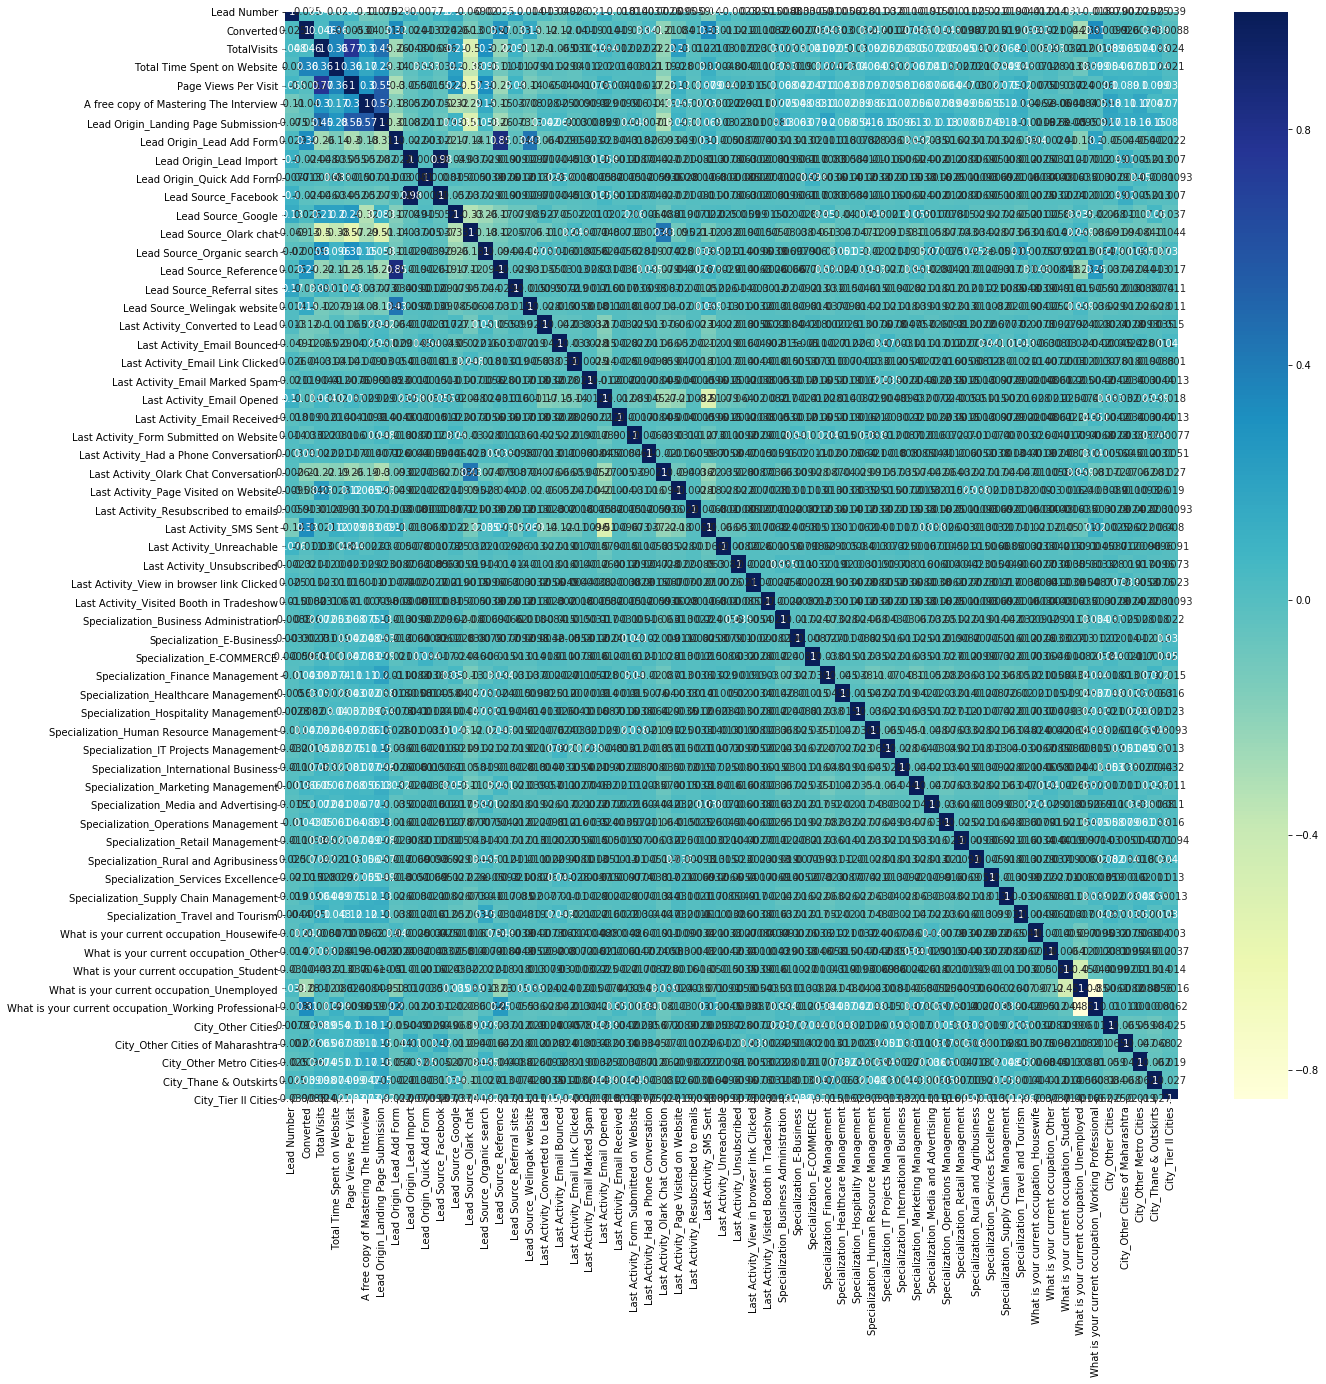

In [141]:
plt.figure(figsize=(20,20))
sns.heatmap(combined.corr(),cmap='YlGnBu',annot=True)

In [142]:
### Dropping highly correlated variables
X_train = X_train.drop(['Lead Origin_Lead Add Form', 'Lead Source_Facebook'], axis=1)
X_test = X_test.drop(['Lead Origin_Lead Add Form', 'Lead Source_Facebook'], axis=1)

In [143]:
X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1871    -1.149699                    -0.885369             -1.266675   
6795     0.299722                     0.006083             -0.516439   
3516     0.662077                    -0.691050              0.143543   
8105     0.662077                     1.365217              1.553761   
3934    -1.149699                    -0.885369             -1.266675   

      A free copy of Mastering The Interview  \
1871                                       0   
6795                                       1   
3516                                       0   
8105                                       0   
3934                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Import  \
1871                                    0                        0   
6795                                    1                        0   
3516                                    0                        0   
8105                                    1                        0   
3934                                    0                        0   

      Lead Origin_Quick Add Form  Lead Source_Google  Lead Source_Olark chat  \
1871                           0                   0                       1   
6795                           0                   0                       0   
3516                           0                   0                       1   
8105                           0                   1                       0   
3934                           0                   0                       1   

      Lead Source_Organic search  ...  \
1871                           0  ...   
6795                           0  ...   
3516                           0  ...   
8105                           0  ...   
3934                           0  ...   

      What is your current occupation_Housewife  \
1871                                          0   
6795                                          0   
3516                                          0   
8105                                          0   
3934                                          0   

      What is your current occupation_Other  \
1871                                      0   
6795                                      0   
3516                                      0   
8105                                      0   
3934                                      0   

      What is your current occupation_Student  \
1871                                        0   
6795                                        0   
3516                                        0   
8105                                        0   
3934                                        0   

      What is your current occupation_Unemployed  \
1871                                           1   
6795                                           1   
3516                                           1   
8105                                           1   
3934                                           1   

      What is your current occupation_Working Professional  City_Other Cities  \
1871                                                  0                     0   
6795                                                  0                     1   
3516                                                  0                     0   
8105                                                  0                     0   
3934                                                  0                     0   

      City_Other Cities of Maharashtra  City_Other Metro Cities  \
1871                                 0                        0   
6795                                 0                        0   
3516                                 0                        0   
8105                                 0                        0   
3934                                 0                        0   

      City_Thane & Outskirts  City_Tier II Citi

In [144]:
X_train.shape

(6468, 56)

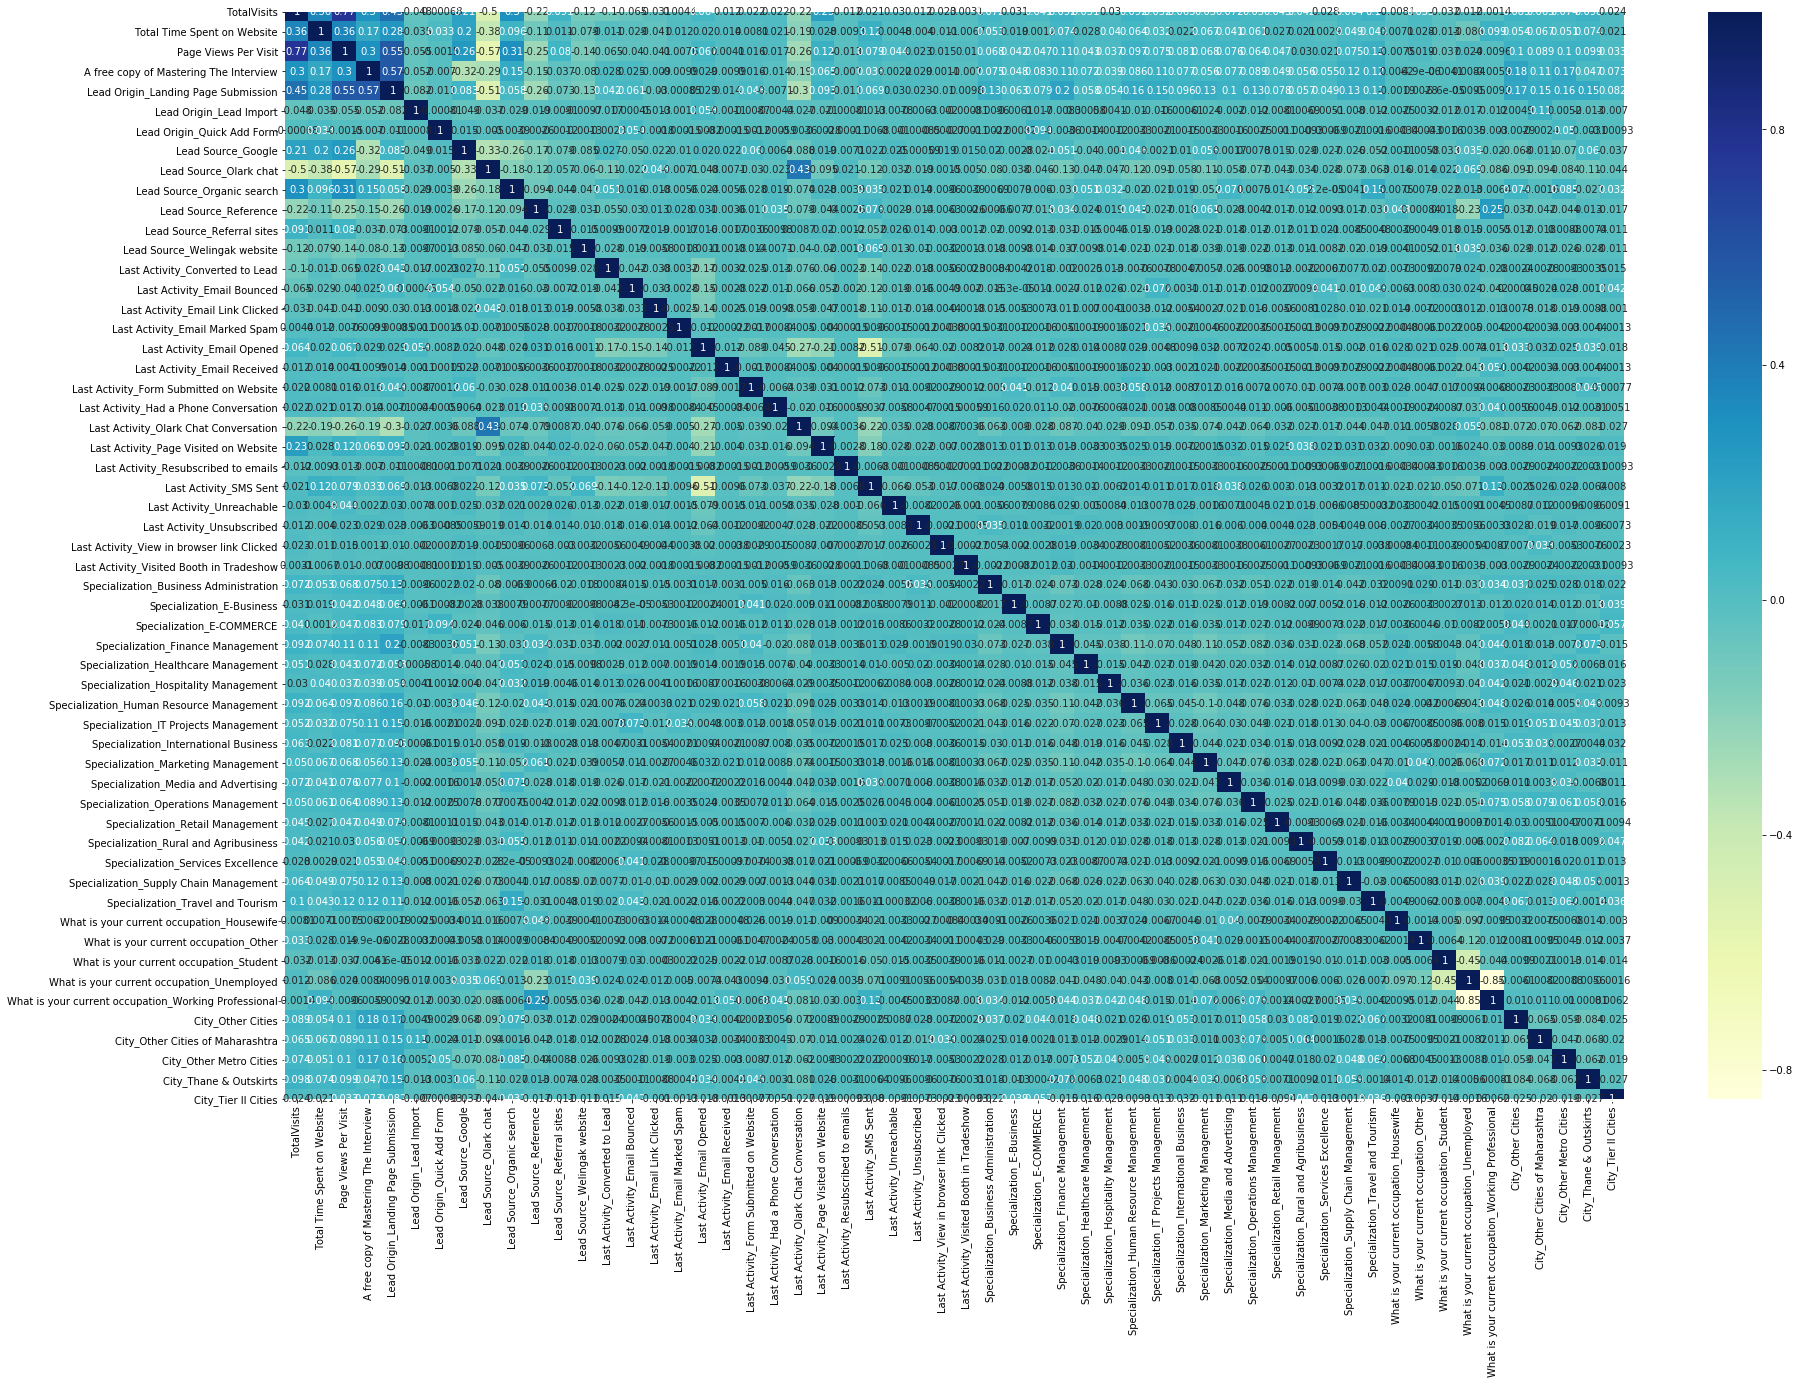

In [145]:
plt.figure(figsize=(30,20))
sns.heatmap(combined[X_train.columns].corr(),cmap='YlGnBu',annot=True)

#### Observation
We have successfully removed the highly corelated variables from the traiing and test datasets.

In [146]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 1871 to 5640
Data columns (total 56 columns):
TotalVisits                                             6468 non-null float64
Total Time Spent on Website                             6468 non-null float64
Page Views Per Visit                                    6468 non-null float64
A free copy of Mastering The Interview                  6468 non-null int64
Lead Origin_Landing Page Submission                     6468 non-null uint8
Lead Origin_Lead Import                                 6468 non-null uint8
Lead Origin_Quick Add Form                              6468 non-null uint8
Lead Source_Google                                      6468 non-null uint8
Lead Source_Olark chat                                  6468 non-null uint8
Lead Source_Organic search                              6468 non-null uint8
Lead Source_Reference                                   6468 non-null uint8
Lead Source_Referral sites                      

## Step 5 Modeling

In [147]:
## Creating Logistic Regression Model
logisticRegressionModel = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logisticRegressionModel.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6411
Model Family:                Binomial   Df Model:                           56
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2687.4
Date:                Mon, 07 Sep 2020   Deviance:                       5374.7
Time:                        23:24:18   Pearson chi2:                 9.66e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   22.0679   2.75e+04      0.001      0.999   -5.38e+04    5.39e+04
TotalVisits                                              0.3701      0.054      6.823      0.000       0.264       0.476
Total Time Spent on Website                              1.0606      0.039     26.878      0.000       0.983       1.138
Page Views Per Visit                                    -0.3785      0.060     -6.282      0.000      -0.497      -0.260
A free copy of Mastering The Interview                  -0.2079      0.106     -1.955      0.051      -0.416       0.000
Lead Origin_Landing Page Submission                     -0.7872      0.128     -6.133      0.000      -1.039      -0.536
Lead Origin_Lead Import                                 -0.6152      0.540     -1.140      0.254      -1.673       0.442
Lead Origin_Quick Add Form                              21.9160   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
Lead Source_Google                                       0.2319      0.112      2.075      0.038       0.013       0.451
Lead Source_Olark chat                                   0.9776      0.160      6.116      0.000       0.664       1.291
Lead Source_Organic search                               0.0737      0.131      0.563      0.573      -0.183       0.330
Lead Source_Reference                                    3.1216      0.243     12.862      0.000       2.646       3.597
Lead Source_Referral sites                              -0.0378      0.322     -0.117      0.907      -0.669       0.594
Lead Source_Welingak website                             5.4307      0.740      7.337      0.000       3.980       6.882
Last Activity_Converted to Lead                        -24.4837   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Bounced                            -25.1132   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Link Clicked                       -23.7713   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Marked Spam                         -1.7197   8.41e+04  -2.05e-05      1.000   -1.65e+05    1.65e+05
Last Activity_Email Opened                             -23.2549   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Email Received                            -2.4554   6.13e+04  -4.01e-05      1.000    -1.2e+05     1.2e+05
Last Activity_Form Submitted on Website                -24.2200   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Had a Phone Conversation                 -21.2802   2.75e+04     -0.001      0.999   -5.39e+04    5.38e+04
Last Activity_Olark Chat Conversation                  -24

### Feature Selection Using RFE

In [148]:
logreg = LogisticRegression()

rfe = RFE(logreg, 15)
rfe= rfe.fit(X_train,y_train)
rfe.support_

array([False,  True, False, False, False, False, False, False,  True,
       False,  True, False,  True,  True,  True, False, False, False,
       False, False,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False])

In [149]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 22),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 21),
 ('A free copy of Mastering The Interview', False, 26),
 ('Lead Origin_Landing Page Submission', False, 7),
 ('Lead Origin_Lead Import', False, 6),
 ('Lead Origin_Quick Add Form', False, 32),
 ('Lead Source_Google', False, 31),
 ('Lead Source_Olark chat', True, 1),
 ('Lead Source_Organic search', False, 42),
 ('Lead Source_Reference', True, 1),
 ('Lead Source_Referral sites', False, 40),
 ('Lead Source_Welingak website', True, 1),
 ('Last Activity_Converted to Lead', True, 1),
 ('Last Activity_Email Bounced', True, 1),
 ('Last Activity_Email Link Clicked', False, 5),
 ('Last Activity_Email Marked Spam', False, 37),
 ('Last Activity_Email Opened', False, 38),
 ('Last Activity_Email Received', False, 36),
 ('Last Activity_Form Submitted on Website', False, 2),
 ('Last Activity_Had a Phone Conversation', True, 1),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activi

In [150]:
col = X_train.columns[rfe.support_]

In [151]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Origin_Quick Add Form', 'Lead Source_Google',
       'Lead Source_Organic search', 'Lead Source_Referral sites',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Marked Spam',
       'Last Activity_Email Opened', 'Last Activity_Email Received',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Page Visited on Website', 'Last Activity_Unreachable',
       'Last Activity_Unsubscribed',
       'Last Activity_View in browser link Clicked',
       'Last Activity_Visited Booth in Tradeshow',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Managem

##### Assessing the model with StatsModels

In [152]:
X_train1= X_train[col]
X_train1

Total Time Spent on Website  Lead Source_Olark chat  \
1871                    -0.885369                       1   
6795                     0.006083                       0   
3516                    -0.691050                       1   
8105                     1.365217                       0   
3934                    -0.885369                       1   
...                           ...                     ...   
350                     -0.885369                       0   
79                       0.404601                       0   
8039                    -0.885369                       1   
6936                    -0.449523                       0   
5640                    -0.885369                       1   

      Lead Source_Reference  Lead Source_Welingak website  \
1871                      0                             0   
6795                      0                             0   
3516                      0                             0   
8105                      0                             0   
3934                      0                             0   
...                     ...                           ...   
350                       0                             0   
79                        1                             0   
8039                      0                             0   
6936                      0                             0   
5640                      0                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
1871                                0                            0   
6795                                0                            0   
3516                                0                            0   
8105                                0                            0   
3934                                0                            0   
...                               ...                          ...   
350                                 0                            0   
79                                  0                            0   
8039                                0                            0   
6936                                1                            0   
5640                                0                            0   

      Last Activity_Had a Phone Conversation  \
1871                                       0   
6795                                       0   
3516                                       0   
8105                                       0   
3934                                       0   
...                                      ...   
350                                        0   
79                                         0   
8039                                       0   
6936                                       0   
5640                                       0   

      Last Activity_Olark Chat Conversation  \
1871                                      0   
6795                                      0   
3516                                      0   
8105                                      0   
3934                                      0   
...                                     ...   
350                                       0   
79                                        0   
8039                                      0   
6936                                      0   
5640                                      0   

      Last Activity_Resubscribed to emails  Last Activity_SMS Sent  \
1871                                     0                       0   
6795                                     0                       0   
3516                                     0                       0   
8105                                     0                       1   
3934                                     0                       0   
...                                    ...                     ...   
350                                      0                       0 

### Model 2

In [153]:
X_train_sm = sm.add_constant(X_train1)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2794.6
Date:                Mon, 07 Sep 2020   Deviance:                       5589.1
Time:                        23:24:20   Pearson chi2:                 9.23e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.9970      1.044     -0.955      0.340      -3.043       1.049
Total Time Spent on Website                              1.0669      0.038     27.991      0.000       0.992       1.142
Lead Source_Olark chat                                   1.1250      0.100     11.279      0.000       0.930       1.321
Lead Source_Reference                                    3.6019      0.201     17.921      0.000       3.208       3.996
Lead Source_Welingak website                             5.4983      0.727      7.558      0.000       4.073       6.924
Last Activity_Converted to Lead                         -1.2162      0.218     -5.589      0.000      -1.643      -0.790
Last Activity_Email Bounced                             -1.8000      0.282     -6.381      0.000      -2.353      -1.247
Last Activity_Had a Phone Conversation                   2.1611      0.652      3.314      0.001       0.883       3.439
Last Activity_Olark Chat Conversation                   -1.3886      0.162     -8.555      0.000      -1.707      -1.070
Last Activity_Resubscribed to emails                    23.8017   4.82e+04      0.000      1.000   -9.44e+04    9.45e+04
Last Activity_SMS Sent                                   1.1892      0.072     16.443      0.000       1.047       1.331
What is your current occupation_Housewife               22.5580   1.37e+04      0.002      0.999   -2.69e+04    2.69e+04
What is your current occupation_Other                   -0.4649      1.314     -0.354      0.723      -3.040       2.110
What is your current occupation_Student                  0.0052      1.067      0.005      0.996      -2.087       2.097
What is your current occupation_Unemployed              -0.4190      1.044     -0.401      0.688      -2.465       1.627
What is your current occupation_Working Professional     2.4174      1.059      2.282      0.022       0.341       4.494
========================================================================================================================
"""

In [154]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

1871    0.225200
6795    0.196311
3516    0.263416
8105    0.773786
3934    0.225200
4844    0.990017
3297    0.100262
8071    0.998997
987     0.120662
7423    0.867601
dtype: float64

In [155]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.22519955, 0.19631084, 0.26341564, 0.77378619, 0.22519955,
       0.99001742, 0.10026225, 0.99899738, 0.12066188, 0.86760093])

In [156]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Lead_Score_Prob':y_train_pred})
y_train_pred_final['Lead'] = y_train.index
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead
0          0         0.225200  1871
1          0         0.196311  6795
2          0         0.263416  3516
3          0         0.773786  8105
4          0         0.225200  3934

#### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [157]:
y_train_pred_final['Final_Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead
0          0         0.225200  1871                         0
1          0         0.196311  6795                         0
2          0         0.263416  3516                         0
3          0         0.773786  8105                         1
4          0         0.225200  3934                         0

In [158]:
from sklearn import metrics
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead)
print(confusion)

[[3578  424]
 [ 882 1584]]


In [159]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead))

0.7980828695114409


In [160]:
### Checking VIF values
vif = pd.DataFrame()
vif['Features'] = X_train1.columns
vif['VIF'] = [variance_inflation_factor(X_train1.values, i) for i in range(X_train1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
13         What is your current occupation_Unemployed  2.15
1                              Lead Source_Olark chat  1.77
9                              Last Activity_SMS Sent  1.63
7               Last Activity_Olark Chat Conversation  1.44
14  What is your current occupation_Working Profes...  1.25
0                         Total Time Spent on Website  1.24
2                               Lead Source_Reference  1.21
4                     Last Activity_Converted to Lead  1.11
5                         Last Activity_Email Bounced  1.07
3                        Lead Source_Welingak website  1.04
12            What is your current occupation_Student  1.03
6              Last Activity_Had a Phone Conversation  1.01
10          What is your current occupation_Housewife  1.01
8                Last Activity_Resubscribed to emails  1.00
11              What is your current occupation_Other  1.00

#### Observation
- The VIF values for all the variables in the model look to be under control
- The p value for **Last Activity_Resubscribed to emails is very high** at 1 & above the threshold 0.05
- We will be dropping Last Activity_Resubscribed to emails in the next model
- Model's accuracy is 79%

### Model 3

In [161]:
X_train2 = X_train1.drop('Last Activity_Resubscribed to emails', axis=1)
X_train2

Total Time Spent on Website  Lead Source_Olark chat  \
1871                    -0.885369                       1   
6795                     0.006083                       0   
3516                    -0.691050                       1   
8105                     1.365217                       0   
3934                    -0.885369                       1   
...                           ...                     ...   
350                     -0.885369                       0   
79                       0.404601                       0   
8039                    -0.885369                       1   
6936                    -0.449523                       0   
5640                    -0.885369                       1   

      Lead Source_Reference  Lead Source_Welingak website  \
1871                      0                             0   
6795                      0                             0   
3516                      0                             0   
8105                      0                             0   
3934                      0                             0   
...                     ...                           ...   
350                       0                             0   
79                        1                             0   
8039                      0                             0   
6936                      0                             0   
5640                      0                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
1871                                0                            0   
6795                                0                            0   
3516                                0                            0   
8105                                0                            0   
3934                                0                            0   
...                               ...                          ...   
350                                 0                            0   
79                                  0                            0   
8039                                0                            0   
6936                                1                            0   
5640                                0                            0   

      Last Activity_Had a Phone Conversation  \
1871                                       0   
6795                                       0   
3516                                       0   
8105                                       0   
3934                                       0   
...                                      ...   
350                                        0   
79                                         0   
8039                                       0   
6936                                       0   
5640                                       0   

      Last Activity_Olark Chat Conversation  Last Activity_SMS Sent  \
1871                                      0                       0   
6795                                      0                       0   
3516                                      0                       0   
8105                                      0                       1   
3934                                      0                       0   
...                                     ...                     ...   
350                                       0                       0   
79                                        0                       0   
8039                                      0                       0   
6936                                      0                       0   
5640                                      0                       0   

      What is your current occupation_Housewife  \
1871                                          0   
6795                                          0   
3516                                          0   
8105                                          0   
3934          

In [162]:
X_train_sm = sm.add_constant(X_train2)
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2796.1
Date:                Mon, 07 Sep 2020   Deviance:                       5592.1
Time:                        23:24:21   Pearson chi2:                 9.22e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.9969      1.044     -0.955      0.340      -3.043       1.049
Total Time Spent on Website                              1.0667      0.038     27.987      0.000       0.992       1.141
Lead Source_Olark chat                                   1.1297      0.100     11.335      0.000       0.934       1.325
Lead Source_Reference                                    3.6015      0.201     17.920      0.000       3.208       3.995
Lead Source_Welingak website                             5.4979      0.727      7.558      0.000       4.072       6.924
Last Activity_Converted to Lead                         -1.2168      0.218     -5.592      0.000      -1.643      -0.790
Last Activity_Email Bounced                             -1.8012      0.282     -6.386      0.000      -2.354      -1.248
Last Activity_Had a Phone Conversation                   2.1603      0.652      3.313      0.001       0.882       3.438
Last Activity_Olark Chat Conversation                   -1.3926      0.162     -8.582      0.000      -1.711      -1.075
Last Activity_SMS Sent                                   1.1877      0.072     16.427      0.000       1.046       1.329
What is your current occupation_Housewife               22.5579   1.37e+04      0.002      0.999   -2.69e+04    2.69e+04
What is your current occupation_Other                   -0.4644      1.314     -0.353      0.724      -3.040       2.111
What is your current occupation_Student                  0.0044      1.067      0.004      0.997      -2.087       2.096
What is your current occupation_Unemployed              -0.4183      1.044     -0.401      0.689      -2.465       1.628
What is your current occupation_Working Professional     2.4174      1.059      2.282      0.022       0.341       4.494
========================================================================================================================
"""

In [163]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [164]:
y_train_pred[:10]

array([0.22619666, 0.19644011, 0.26451656, 0.77362305, 0.22619666,
       0.99000013, 0.10034955, 0.99899634, 0.12067293, 0.86747974])

In [165]:
y_train_pred_final['Lead_Score_Prob'] = y_train_pred

In [166]:
y_train_pred_final['Final_Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead
0          0         0.226197  1871                         0
1          0         0.196440  6795                         0
2          0         0.264517  3516                         0
3          0         0.773623  8105                         1
4          0         0.226197  3934                         0

In [167]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead)
print(confusion)

[[3576  426]
 [ 883 1583]]


In [168]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead))

0.7976190476190477


In [169]:
vif = pd.DataFrame()
vif['Features'] = X_train2.columns
vif['VIF'] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
12         What is your current occupation_Unemployed  2.15
1                              Lead Source_Olark chat  1.76
8                              Last Activity_SMS Sent  1.63
7               Last Activity_Olark Chat Conversation  1.44
13  What is your current occupation_Working Profes...  1.25
0                         Total Time Spent on Website  1.24
2                               Lead Source_Reference  1.21
4                     Last Activity_Converted to Lead  1.11
5                         Last Activity_Email Bounced  1.07
3                        Lead Source_Welingak website  1.04
11            What is your current occupation_Student  1.03
6              Last Activity_Had a Phone Conversation  1.01
9           What is your current occupation_Housewife  1.01
10              What is your current occupation_Other  1.00

#### Observation
- The VIF values for all the variables in the model look to be under control
- The p value for What is your current occupation_Housewife is very high at 0.999 & above the threshold 0.05
- We will be dropping What is your current occupation_Housewife in the next model
- Accuracy is same as previous model 79.80

### Model 4

In [170]:
X_train3 = X_train2.drop('What is your current occupation_Housewife', axis=1)
X_train3.columns

Index(['Total Time Spent on Website', 'Lead Source_Olark chat',
       'Lead Source_Reference', 'Lead Source_Welingak website',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [171]:
X_train_sm = sm.add_constant(X_train3)
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2799.0
Date:                Mon, 07 Sep 2020   Deviance:                       5598.1
Time:                        23:24:21   Pearson chi2:                 9.22e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.6403      0.759      0.844      0.399      -0.847       2.128
Total Time Spent on Website                              1.0658      0.038     27.974      0.000       0.991       1.140
Lead Source_Olark chat                                   1.1275      0.100     11.315      0.000       0.932       1.323
Lead Source_Reference                                    3.5995      0.201     17.922      0.000       3.206       3.993
Lead Source_Welingak website                             5.4962      0.727      7.556      0.000       4.070       6.922
Last Activity_Converted to Lead                         -1.2174      0.218     -5.596      0.000      -1.644      -0.791
Last Activity_Email Bounced                             -1.8013      0.282     -6.388      0.000      -2.354      -1.249
Last Activity_Had a Phone Conversation                   2.1590      0.652      3.311      0.001       0.881       3.437
Last Activity_Olark Chat Conversation                   -1.3984      0.162     -8.613      0.000      -1.717      -1.080
Last Activity_SMS Sent                                   1.1870      0.072     16.421      0.000       1.045       1.329
What is your current occupation_Other                   -2.1001      1.102     -1.905      0.057      -4.260       0.060
What is your current occupation_Student                 -1.6315      0.791     -2.062      0.039      -3.183      -0.080
What is your current occupation_Unemployed              -2.0543      0.760     -2.703      0.007      -3.544      -0.565
What is your current occupation_Working Professional     0.7811      0.781      1.001      0.317      -0.749       2.311
========================================================================================================================
"""

In [172]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [173]:
y_train_pred[:10]

array([0.22617583, 0.19663145, 0.26445664, 0.77347022, 0.22617583,
       0.98998366, 0.10052366, 0.99899419, 0.12067648, 0.86731123])

In [174]:
y_train_pred_final['Lead_Score_Prob'] = y_train_pred

In [175]:
y_train_pred_final['Final_Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead
0          0         0.226176  1871                         0
1          0         0.196631  6795                         0
2          0         0.264457  3516                         0
3          0         0.773470  8105                         1
4          0         0.226176  3934                         0

In [176]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead)
print(confusion)

[[3575  427]
 [ 884 1582]]


In [177]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead))

0.7973098330241187


In [178]:
vif = pd.DataFrame()
vif['Features'] = X_train3.columns
vif['VIF'] = [variance_inflation_factor(X_train3.values, i) for i in range(X_train3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
11         What is your current occupation_Unemployed  2.15
1                              Lead Source_Olark chat  1.76
8                              Last Activity_SMS Sent  1.63
7               Last Activity_Olark Chat Conversation  1.44
12  What is your current occupation_Working Profes...  1.25
0                         Total Time Spent on Website  1.24
2                               Lead Source_Reference  1.20
4                     Last Activity_Converted to Lead  1.11
5                         Last Activity_Email Bounced  1.07
3                        Lead Source_Welingak website  1.04
10            What is your current occupation_Student  1.03
6              Last Activity_Had a Phone Conversation  1.01
9               What is your current occupation_Other  1.00

#### Observation
The p value for What is your current occupation_Working Professional is above the threshold at 0.440

Accuracy is same as previous model 79.80

We will be dropping this variable in the next model

### Model 5

In [179]:
X_train4 = X_train3.drop('What is your current occupation_Working Professional', axis=1)
X_train4.columns 

Index(['Total Time Spent on Website', 'Lead Source_Olark chat',
       'Lead Source_Reference', 'Lead Source_Welingak website',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed'],
      dtype='object')

In [180]:
X_train_sm = sm.add_constant(X_train4)
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2799.5
Date:                Mon, 07 Sep 2020   Deviance:                       5599.0
Time:                        23:24:22   Pearson chi2:                 9.11e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.3837      0.179      7.726      0.000       1.033       1.735
Total Time Spent on Website                    1.0659      0.038     27.980      0.000       0.991       1.141
Lead Source_Olark chat                         1.1280      0.100     11.322      0.000       0.933       1.323
Lead Source_Reference                          3.5984      0.201     17.914      0.000       3.205       3.992
Lead Source_Welingak website                   5.4963      0.727      7.556      0.000       4.071       6.922
Last Activity_Converted to Lead               -1.2127      0.217     -5.585      0.000      -1.638      -0.787
Last Activity_Email Bounced                   -1.7984      0.282     -6.383      0.000      -2.351      -1.246
Last Activity_Had a Phone Conversation         2.1604      0.652      3.314      0.001       0.883       3.438
Last Activity_Olark Chat Conversation         -1.4009      0.162     -8.624      0.000      -1.719      -1.083
Last Activity_SMS Sent                         1.1884      0.072     16.449      0.000       1.047       1.330
What is your current occupation_Other         -2.8435      0.819     -3.471      0.001      -4.449      -1.238
What is your current occupation_Student       -2.3752      0.286     -8.313      0.000      -2.935      -1.815
What is your current occupation_Unemployed    -2.7984      0.180    -15.540      0.000      -3.151      -2.445
==============================================================================================================
"""

In [181]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [182]:
y_train_pred[:10]

array([0.22612238, 0.19652651, 0.26440383, 0.77364975, 0.22612238,
       0.98962089, 0.10045202, 0.99895586, 0.12112154, 0.86744134])

In [183]:
y_train_pred_final['Lead_Score_Prob'] = y_train_pred

In [184]:
y_train_pred_final['Final_Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead
0          0         0.226122  1871                         0
1          0         0.196527  6795                         0
2          0         0.264404  3516                         0
3          0         0.773650  8105                         1
4          0         0.226122  3934                         0

In [185]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead)
print(confusion)

[[3575  427]
 [ 884 1582]]


In [186]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead))

0.7973098330241187


In [187]:
vif = pd.DataFrame()
vif['Features'] = X_train4.columns
vif['VIF'] = [variance_inflation_factor(X_train4.values, i) for i in range(X_train4.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
11  What is your current occupation_Unemployed  2.01
1                       Lead Source_Olark chat  1.73
8                       Last Activity_SMS Sent  1.50
7        Last Activity_Olark Chat Conversation  1.43
0                  Total Time Spent on Website  1.21
2                        Lead Source_Reference  1.09
4              Last Activity_Converted to Lead  1.09
5                  Last Activity_Email Bounced  1.07
3                 Lead Source_Welingak website  1.04
10     What is your current occupation_Student  1.03
6       Last Activity_Had a Phone Conversation  1.01
9        What is your current occupation_Other  1.00

### Observation
Model 5 meets all our criteria:

- The VIF values are under 3
- The p values are under 0.05
- The 12 selected features look significant

Let us generate a heatmap to confirm that there is no multicollinearity

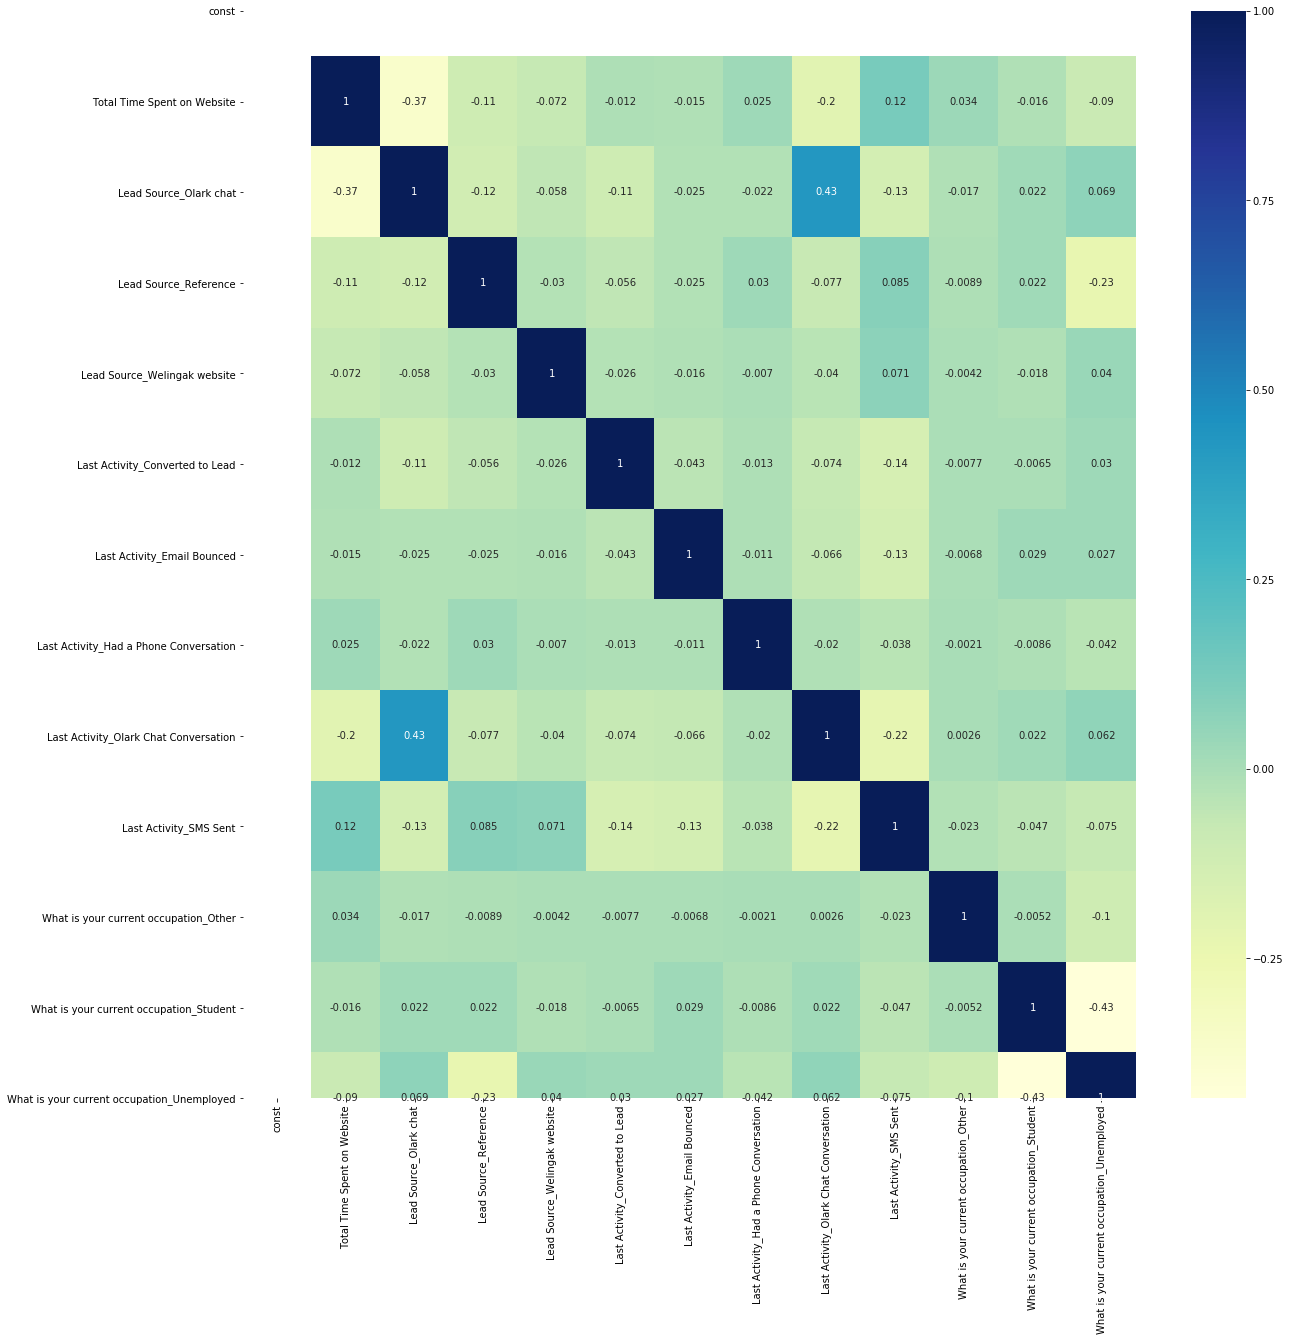

In [188]:
plt.figure(figsize=(20,20))
sns.heatmap(X_train_sm.corr(),cmap='YlGnBu',annot=True)

#### Observation
As we can confirm with our heatmap, there is no multicollinearity in the model.

#### Generating predicted values on the training set

In [189]:
y_train_pred = res.predict(X_train_sm)
y_train_pred.head()

1871    0.226122
6795    0.196527
3516    0.264404
8105    0.773650
3934    0.226122
dtype: float64

In [190]:
y_train_pred_final['Final_Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead
0          0         0.226122  1871                         0
1          0         0.196527  6795                         0
2          0         0.264404  3516                         0
3          0         0.773650  8105                         1
4          0         0.226122  3934                         0

In [191]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead)
print(confusion)

[[3575  427]
 [ 884 1582]]


In [192]:
# Let's check the overall accuracy.
print(round(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead),2))

0.8


#### Creating new column 'Lead_Score'
Lead_Score would be equal to (Lead_Score_Prob * 100)

In [193]:
y_train_pred_final['Lead_Score'] = round((y_train_pred_final['Lead_Score_Prob'] * 100),0)

y_train_pred_final['Lead_Score'] = y_train_pred_final['Lead_Score'].astype('int')

# Let's see the head
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead  Lead_Score
0          0         0.226122  1871                         0          23
1          0         0.196527  6795                         0          20
2          0         0.264404  3516                         0          26
3          0         0.773650  8105                         1          77
4          0         0.226122  3934                         0          23

In [194]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [195]:
# Let's see the sensitivity of our logistic regression model
round((TP / float(TP+FN)),2)

0.64

In [196]:
# Let us calculate specificity
round((TN / float(TN+FP)),2)

0.89

#### Observation
Based on the above statistics for Accuracy(80%), Sensitivity(64%) and Specificity(89%) we can say that our trained model is currently highly specific but not very sensitive. Our objective is to create a highly sensitive model with 80% sensitivity. Let us find cut-off values using ROC curves to improve this.

#### Plotting the ROC Curve

In [197]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [198]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Lead_Score_Prob, drop_intermediate = False )

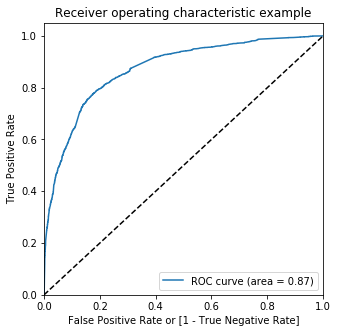

In [199]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Lead_Score_Prob)

#### Observation
From the ROC curve we can say that the model will be able to provide us with a good result overall.

### Finding Optimal Cutoff Point
Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [200]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead  Lead_Score  \
0          0         0.226122  1871                         0          23   
1          0         0.196527  6795                         0          20   
2          0         0.264404  3516                         0          26   
3          0         0.773650  8105                         1          77   
4          0         0.226122  3934                         0          23   

   0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  
0    1    1    1    0    0    0    0    0    0    0  
1    1    1    0    0    0    0    0    0    0    0  
2    1    1    1    0    0    0    0    0    0    0  
3    1    1    1    1    1    1    1    1    0    0  
4    1    1    1    0    0    0    0    0    0    0

In [201]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificty'])


num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     Probability  Accuracy  Sensitivity  Specificty
0.0          0.0  0.381262     1.000000    0.000000
0.1          0.1  0.572202     0.969181    0.327586
0.2          0.2  0.716141     0.920925    0.589955
0.3          0.3  0.786797     0.824412    0.763618
0.4          0.4  0.810142     0.755880    0.843578
0.5          0.5  0.797310     0.641525    0.893303
0.6          0.6  0.787415     0.570154    0.921289
0.7          0.7  0.774428     0.493512    0.947526
0.8          0.8  0.742424     0.370235    0.971764
0.9          0.9  0.710730     0.257908    0.989755


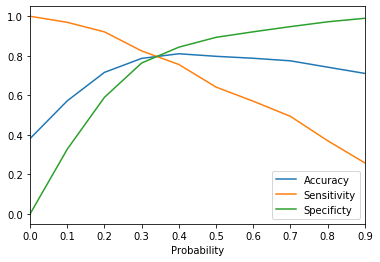

In [202]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificty'])
plt.show()

#### Observation
From the above curve we can see that the optimal cutoff is at 0.33. This is the point where all the parameters are equally balanced

In [203]:
y_train_pred_final['Final_Predicted_Hot_Lead'] = y_train_pred_final.Lead_Score_Prob.map( lambda x: 1 if x > 0.33 else 0)

y_train_pred_final.head()

Converted  Lead_Score_Prob  Lead  Final_Predicted_Hot_Lead  Lead_Score  \
0          0         0.226122  1871                         0          23   
1          0         0.196527  6795                         0          20   
2          0         0.264404  3516                         0          26   
3          0         0.773650  8105                         1          77   
4          0         0.226122  3934                         0          23   

   0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  
0    1    1    1    0    0    0    0    0    0    0  
1    1    1    0    0    0    0    0    0    0    0  
2    1    1    1    0    0    0    0    0    0    0  
3    1    1    1    1    1    1    1    1    0    0  
4    1    1    1    0    0    0    0    0    0    0

In [204]:
# Accuracy
round(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead),2)

0.8

In [205]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted_Hot_Lead )
confusion2

array([[3169,  833],
       [ 490, 1976]], dtype=int64)

In [206]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [207]:
# Let's see the sensitivity of our logistic regression model
round(TP / float(TP+FN),2)

0.8

In [208]:
# Let us calculate specificity
round(TN / float(TN+FP),2)

0.79

#### Observation
As we can see above, when we are selecting the optimal cutoff = 0.33, the various performance parameters Accuracy, Sensitivity & Specificity are all around 80%

This meets our objective of getting a highly sensitive model with 80% sensitivity

### Precision and Recall Curve

In [209]:
### Calculating Precision
precision =round(TP/float(TP+FP),2)
precision

0.7

In [210]:
### Calculating Recall
recall = round(TP/float(TP+FN),2)
recall

0.8

#### Observation
From the above scores we note that our model has a good overall relevancy, defined by Precision, at 70% & a great return of relevant results, defined by Recall, at 80%.

For the purposes of our model we will focus on the Recall result as we would not like to miss out on any hot leads that are willing to be converted.

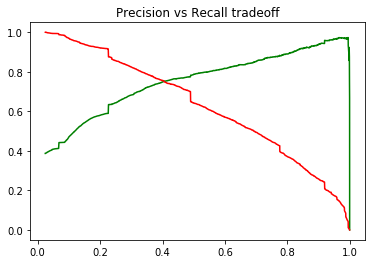

In [211]:
### Let us generate the Precision vs Recall tradeoff curve 
p ,r, thresholds=precision_recall_curve(y_train_pred_final.Converted,y_train_pred_final['Lead_Score_Prob'])
plt.title('Precision vs Recall tradeoff')
plt.plot(thresholds, p[:-1], "g-")    # Plotting precision
plt.plot(thresholds, r[:-1], "r-")    # Plotting Recall
plt.show()

#### Observation
The precision vs recall tradeoff value from the above graph is at 0.4

In [212]:
### The F statistic is given by 2 * (precision * recall) / (precision + recall)
## The F score is used to measure a test's accuracy, and it balances the use of precision and recall to do it.
### The F score can provide a more realistic measure of a test's performance by using both precision and recall
F1 =2 * (precision * recall) / (precision + recall)
round(F1,2)

0.75

#### Observation
Based on the F1 score we can say that our model is fairly accurate. Let us test this accuracy on the test set.

### Making Predictions on test set

In [213]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits',
                                'Total Time Spent on Website','Page Views Per Visit']])

In [214]:
X_train4.shape

(6468, 12)

In [215]:
X_test = X_test[X_train4.columns]

X_test.shape

(2772, 12)

In [216]:
X_test.head()

Total Time Spent on Website  Lead Source_Olark chat  \
4269                     0.964503                       0   
2376                    -0.885369                       0   
7766                    -0.777780                       0   
9199                    -0.885369                       1   
4359                    -0.885369                       0   

      Lead Source_Reference  Lead Source_Welingak website  \
4269                      0                             0   
2376                      1                             0   
7766                      0                             0   
9199                      0                             0   
4359                      1                             0   

      Last Activity_Converted to Lead  Last Activity_Email Bounced  \
4269                                0                            0   
2376                                0                            0   
7766                                0                            0   
9199                                0                            0   
4359                                0                            0   

      Last Activity_Had a Phone Conversation  \
4269                                       0   
2376                                       0   
7766                                       0   
9199                                       0   
4359                                       0   

      Last Activity_Olark Chat Conversation  Last Activity_SMS Sent  \
4269                                      0                       1   
2376                                      0                       1   
7766                                      0                       0   
9199                                      1                       0   
4359                                      0                       0   

      What is your current occupation_Other  \
4269                                      0   
2376                                      0   
7766                                      0   
9199                                      0   
4359                                      0   

      What is your current occupation_Student  \
4269                                        0   
2376                                        0   
7766                                        0   
9199                                        0   
4359                                        0   

      What is your current occupation_Unemployed  
4269                                           1  
2376                                           1  
7766                                           0  
9199                                           1  
4359                                           1

In [217]:
X_test_sm = sm.add_constant(X_test)

##### Making predictions on the test set

In [218]:
y_test_pred = res.predict(X_test_sm)

In [219]:
y_test_pred[:10]

4269    0.690380
2376    0.918972
7766    0.635218
9199    0.067156
4359    0.775571
9186    0.505920
1631    0.405401
8963    0.137610
8007    0.052129
5324    0.297859
dtype: float64

In [220]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

0
4269  0.690380
2376  0.918972
7766  0.635218
9199  0.067156
4359  0.775571

In [221]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [222]:
y_test_df['Lead'] = y_test_df.index

In [223]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [224]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [225]:
y_pred_final.shape

(2772, 3)

In [226]:
# Renaming the column 

y_pred_final= y_pred_final.rename(columns={ 0 : 'Lead_Score_Prob'})

In [227]:
# Rearranging the columns

y_pred_final = y_pred_final.reindex(['Lead','Converted','Lead_Score_Prob'], axis=1)

In [228]:
# Adding Lead_Score column

y_pred_final['Lead_Score'] = round((y_pred_final['Lead_Score_Prob'] * 100),0)

y_pred_final['Lead_Score'] = y_pred_final['Lead_Score'].astype(int)

In [229]:
# Let's see the head of y_pred_final
y_pred_final.head()

Lead  Converted  Lead_Score_Prob  Lead_Score
0  4269          1         0.690380          69
1  2376          1         0.918972          92
2  7766          1         0.635218          64
3  9199          0         0.067156           7
4  4359          1         0.775571          78

In [230]:
y_pred_final['Final_Predicted_Hot_Lead'] = y_pred_final.Lead_Score_Prob.map(lambda x: 1 if x > 0.33 else 0)

In [231]:
y_pred_final.head()

Lead  Converted  Lead_Score_Prob  Lead_Score  Final_Predicted_Hot_Lead
0  4269          1         0.690380          69                         1
1  2376          1         0.918972          92                         1
2  7766          1         0.635218          64                         1
3  9199          0         0.067156           7                         0
4  4359          1         0.775571          78                         1

In [232]:
# Let's check the overall accuracy.
round(metrics.accuracy_score(y_pred_final.Converted, y_pred_final.Final_Predicted_Hot_Lead),2)

0.8

In [233]:
confusion3 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.Final_Predicted_Hot_Lead )
confusion3

array([[1346,  331],
       [ 217,  878]], dtype=int64)

In [234]:
TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives

In [235]:
# Let's see the sensitivity of our logistic regression model
round((TP / float(TP+FN)),2)

0.8

In [236]:
# Let us calculate specificity
round(TN / float(TN+FP),2)

0.8

#### Observation And Conclusion (on Test Set)
As we can see above when cut-off = 0.33, the various Model Performance parameters on test set are as per below
- Sensitivity = 80%
- Specificity = 80%
- Accuracy = 80%%

All the 3 performance parameters on test set appear to be almost same with no much variation, so we are good with the modeling now.

### Final Model Reporting & Equation

**log odds = 1.3837 +(1.0659 Total Time Spent on Website) + (1.1280 Lead Source_Olark chat) + (3.5984 Lead Source_Reference) + (5.4963 Lead Source_Welingak website) + (-1.2127 Last Activity_Converted to Lead) + (-1.7984 Last Activity_Email Bounced) + (2.1604 Last Activity_Had a Phone Conversation) + (-1.4009 Last Activity_Olark Chat Conversation) + (1.1884 Last Activity_SMS Sent)+(-2.8435 What is your current occupation_Other)+(-2.3752 What is your current occupation_Student)+(-2.7984 * What is your current occupation_Unemployed)**

### Insights
- Hot Leads are identified as 'Customers having lead score of 33 or above'
- Sales Team of the company should first focus on the 'Hot Leads'
- Higher the Lead Score, higher the chances of conversion of 'Hot Leads' into 'Paying Customers'
- The 'Cold Leads'(Customer having lead score < 33) should be focused after the Sales Team is done with the 'Hot Leads'

### Generating Lead score on original Table
Assigning Lead score to the respective lead numbers present in our original dataset.

### For training set

In [237]:
y_train_pred_final = y_train_pred_final.reindex(['Lead','Converted','Lead_Score_Prob','Lead_Score','Final_Predicted_Hot_Lead'], axis=1)
y_train_pred_final

Lead  Converted  Lead_Score_Prob  Lead_Score  Final_Predicted_Hot_Lead
0     1871          0         0.226122          23                         0
1     6795          0         0.196527          20                         0
2     3516          0         0.264404          26                         0
3     8105          0         0.773650          77                         1
4     3934          0         0.226122          23                         0
...    ...        ...              ...         ...                       ...
6463   350          1         0.086401           9                         0
6464    79          1         0.995564         100                         1
6465  8039          1         0.226122          23                         0
6466  6936          0         0.042842           4                         0
6467  5640          0         0.226122          23                         0

[6468 rows x 5 columns]

In [238]:
### Generating table
resultingTable1 = pd.merge(y_train_pred_final,df,how='inner',left_on='Lead',right_index=True)
resultingTable1[['Lead Number','Lead_Score']].head()

Lead Number  Lead_Score
0       641410          23
1       597687          20
2       626825          26
3       587928          77
4       622366          23

### For testing set

In [239]:
### Generating table
resultingTable2 = pd.merge(y_pred_final,df,how='inner',left_on='Lead',right_index=True)
resultingTable2[['Lead Number','Lead_Score']].head()

Lead Number  Lead_Score
0       619003          69
1       636884          92
2       590281          64
3       579892           7
4       617929          78

### Merging both resulting tabel

In [240]:
result_df= pd.concat([resultingTable1, resultingTable2])

In [241]:
result_df

Lead  Converted_x  Lead_Score_Prob  Lead_Score  \
0     1871            0         0.226122          23   
1     6795            0         0.196527          20   
2     3516            0         0.264404          26   
3     8105            0         0.773650          77   
4     3934            0         0.226122          23   
...    ...          ...              ...         ...   
2767  8649            0         0.142686          14   
2768  2152            1         0.236860          24   
2769  7101            0         0.226122          23   
2770  5331            0         0.685222          69   
2771  2960            1         0.918972          92   

      Final_Predicted_Hot_Lead  Lead Number              Lead Origin  \
0                            0       641410                      API   
1                            0       597687  Landing Page Submission   
2                            0       626825                      API   
3                            1       587928  Landing Page Submission   
4                            0       622366                      API   
...                        ...          ...                      ...   
2767                         0       583730  Landing Page Submission   
2768                         0       639134            Lead Add Form   
2769                         0       595041                      API   
2770                         1       608916  Landing Page Submission   
2771                         1       631408            Lead Add Form   

         Lead Source  Converted_y  TotalVisits  Total Time Spent on Website  \
0         Olark chat            0          0.0                         0.00   
1     Direct traffic            0          4.0                         8.12   
2         Olark chat            0          5.0                         1.77   
3             Google            0          5.0                        20.50   
4         Olark chat            0          0.0                         0.00   
...              ...          ...          ...                          ...   
2767  Direct traffic            0         10.0                         4.83   
2768          Google            1          0.0                         0.00   
2769      Olark chat            0          0.0                         0.00   
2770  Direct traffic            0          3.0                        26.80   
2771       Reference            1          0.0                         0.00   

      Page Views Per Visit            Last Activity           Specialization  \
0                     0.00             Email Opened     Marketing Management   
1                     1.33             Email Opened                   Others   
2                     2.50             Email Opened                   Others   
3                     5.00                 SMS Sent      Services Excellence   
4                     0.00             Email Opened                   Others   
...                    ...                      ...                      ...   
2767                  1.50  Page Visited on Website  Supply Chain Management   
2768                  0.00                 SMS Sent                   Others   
2769                  0.00             Email Opened                   Others   
2770                  3.00  Page Visited on Website       Travel and Tourism   
2771                  0.00                 SMS Sent                   Others   

     What is your current occupation          City  \
0                         Unemployed        Mumbai   
1                         Unemployed  Other Cities   
2                         Unemployed        Mumbai   
3                         Unemployed        Mumbai   
4                         Unemployed        Mumbai   
...                              ...           ...   
2767                      Unemployed        Mumbai   
2768                      Unemployed        Mumbai   
2769                      Unemployed        Mumbai   
2770              

In [242]:
### renaming Converted_x to Converted and droping Converted_y as both are same
result_df=result_df.rename(columns={'Converted_x' : 'Converted'})
result_df= result_df.drop(['Converted_y'], axis=1)

In [243]:
result_df

Lead  Converted  Lead_Score_Prob  Lead_Score  Final_Predicted_Hot_Lead  \
0     1871          0         0.226122          23                         0   
1     6795          0         0.196527          20                         0   
2     3516          0         0.264404          26                         0   
3     8105          0         0.773650          77                         1   
4     3934          0         0.226122          23                         0   
...    ...        ...              ...         ...                       ...   
2767  8649          0         0.142686          14                         0   
2768  2152          1         0.236860          24                         0   
2769  7101          0         0.226122          23                         0   
2770  5331          0         0.685222          69                         1   
2771  2960          1         0.918972          92                         1   

      Lead Number              Lead Origin     Lead Source  TotalVisits  \
0          641410                      API      Olark chat          0.0   
1          597687  Landing Page Submission  Direct traffic          4.0   
2          626825                      API      Olark chat          5.0   
3          587928  Landing Page Submission          Google          5.0   
4          622366                      API      Olark chat          0.0   
...           ...                      ...             ...          ...   
2767       583730  Landing Page Submission  Direct traffic         10.0   
2768       639134            Lead Add Form          Google          0.0   
2769       595041                      API      Olark chat          0.0   
2770       608916  Landing Page Submission  Direct traffic          3.0   
2771       631408            Lead Add Form       Reference          0.0   

      Total Time Spent on Website  Page Views Per Visit  \
0                            0.00                  0.00   
1                            8.12                  1.33   
2                            1.77                  2.50   
3                           20.50                  5.00   
4                            0.00                  0.00   
...                           ...                   ...   
2767                         4.83                  1.50   
2768                         0.00                  0.00   
2769                         0.00                  0.00   
2770                        26.80                  3.00   
2771                         0.00                  0.00   

                Last Activity           Specialization  \
0                Email Opened     Marketing Management   
1                Email Opened                   Others   
2                Email Opened                   Others   
3                    SMS Sent      Services Excellence   
4                Email Opened                   Others   
...                       ...                      ...   
2767  Page Visited on Website  Supply Chain Management   
2768                 SMS Sent                   Others   
2769             Email Opened                   Others   
2770  Page Visited on Website       Travel and Tourism   
2771                 SMS Sent                   Others   

     What is your current occupation          City  \
0                         Unemployed        Mumbai   
1                         Unemployed  Other Cities   
2                         Unemployed        Mumbai   
3                         Unemployed        Mumbai   
4                         Unemployed        Mumbai   
...                              ...           ...   
2767                      Unemployed        Mumbai   
2768                      Unemployed        Mumbai   
2769                      Unemployed        Mumbai   
2770                      Unemployed        Mumbai   
2771                      Unemployed        Mumbai   

      A free copy of Mastering The Interview  
0                                         

### Observation
From the resultant shape we can confirm that the number of rows in the final dataset are the same as it's in original. Therefore we can use the values from the 'result_df' dataset to pursue the leads.based on the key insights identified above.

In [244]:
# coefficients of our final model 

pd.options.display.float_format = '{:.2f}'.format
new_params = res.params[1:]
new_params

Total Time Spent on Website                   1.07
Lead Source_Olark chat                        1.13
Lead Source_Reference                         3.60
Lead Source_Welingak website                  5.50
Last Activity_Converted to Lead              -1.21
Last Activity_Email Bounced                  -1.80
Last Activity_Had a Phone Conversation        2.16
Last Activity_Olark Chat Conversation        -1.40
Last Activity_SMS Sent                        1.19
What is your current occupation_Other        -2.84
What is your current occupation_Student      -2.38
What is your current occupation_Unemployed   -2.80
dtype: float64

In [245]:
# Getting a relative coeffient value for all the features wrt the feature with the highest coefficient

feature_importance = new_params
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance

Total Time Spent on Website                   19.39
Lead Source_Olark chat                        20.52
Lead Source_Reference                         65.47
Lead Source_Welingak website                 100.00
Last Activity_Converted to Lead              -22.06
Last Activity_Email Bounced                  -32.72
Last Activity_Had a Phone Conversation        39.31
Last Activity_Olark Chat Conversation        -25.49
Last Activity_SMS Sent                        21.62
What is your current occupation_Other        -51.73
What is your current occupation_Student      -43.21
What is your current occupation_Unemployed   -50.91
dtype: float64

### Proposal:
- X Education Sales Team should give attention to below key pointes inferred from the model to make conversion rate high:

- Organization should come-up with more effective incentive offers(referral bonus, discount as per company policy) to convert the leads into student.

- Working professionals will be better leads due to their high conversion percentage.

- They should follow-up more with the referred individuals and the leads spending more time on website as their conversion rate are high.  

- Overall, it is safe to say that the more time the user spends on the website, the better their chances of becoming a student.

- Leads who had call to our customer care or sent messages as their last activity should be our targeted customer.

- They should first focus on the 'Hot Leads‘(Leads having score of 33 or above)

- Higher the Lead Score, higher the chances of conversion of 'Hot Leads' into 'Paying Customers‘

- The 'Cold Leads'(Customer having lead score < 33) should be focused after the Sales Team is done with the 'Hot Leads‘ and should provide some discount as per company policy and do follow-ups to clear their doubts about the platform.
